# ETL - EDA 
#### Dataframes obtenidos del Observatorio de Seguridad Vial del Gobierno de Buenos Aires
Contamos con dos datasets, uno de siniestros viales ocurridos en Buenos Aires entre los años 2016 a 2022, el segundo set de datos nos aporta más información sobre la víctima y su rol en el accidente.

## Links complementarios
+ https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/victimas-siniestros-viales/NOTAS_HOMICIDIOS_SINIESTRO_VIAL.pdf
+ https://docs.google.com/spreadsheets/d/1Op98U-Hh2a3Q7uuznAzdl4Bf8r8qPr4m/edit?gid=1771770012#gid=1771770012

## Librerías

In [114]:
import pandas as pd
from ydata_profiling import ProfileReport
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fuzzywuzzy import fuzz
import re


## Carga de archivos
Se cargaron los archivos directamente de un archivo xlsx

In [115]:
route = (r'C:\Users\user\OneDrive\Escritorio\SOYHENRY\Curso Data Science\PI2\homicidios.xlsx')

In [116]:
dfsiniestros = pd.read_excel(route)
print(dfsiniestros.head())

          ID  N_VICTIMAS      FECHA  AAAA  MM  DD      HORA HH  \
0  2016-0001           1 2016-01-01  2016   1   1  04:00:00  4   
1  2016-0002           1 2016-01-02  2016   1   2  01:15:00  1   
2  2016-0003           1 2016-01-03  2016   1   3  07:00:00  7   
3  2016-0004           1 2016-01-10  2016   1  10  00:00:00  0   
4  2016-0005           1 2016-01-21  2016   1  21  05:20:00  5   

                             LUGAR_DEL_HECHO TIPO_DE_CALLE  ...  Altura  \
0  AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ       AVENIDA  ...     NaN   
1          AV GRAL PAZ  Y AV DE LOS CORRALES      GRAL PAZ  ...     NaN   
2                         AV ENTRE RIOS 2034       AVENIDA  ...  2034.0   
3      AV LARRAZABAL Y GRAL VILLEGAS CONRADO       AVENIDA  ...     NaN   
4  AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA        AVENIDA  ...     NaN   

                                 Cruce  \
0  FERNANDEZ DE LA CRUZ, F., GRAL. AV.   
1                  DE LOS CORRALES AV.   
2                         

In [117]:
dfvictimas = pd.read_excel(route, sheet_name= 'VICTIMAS')
print(dfvictimas.head())

    ID_hecho      FECHA  AAAA  MM  DD        ROL VICTIMA       SEXO EDAD  \
0  2016-0001 2016-01-01  2016   1   1  CONDUCTOR    MOTO  MASCULINO   19   
1  2016-0002 2016-01-02  2016   1   2  CONDUCTOR    AUTO  MASCULINO   70   
2  2016-0003 2016-01-03  2016   1   3  CONDUCTOR    MOTO  MASCULINO   30   
3  2016-0004 2016-01-10  2016   1  10  CONDUCTOR    MOTO  MASCULINO   18   
4  2016-0005 2016-01-21  2016   1  21  CONDUCTOR    MOTO  MASCULINO   29   

   FECHA_FALLECIMIENTO  
0  2016-01-01 00:00:00  
1  2016-01-02 00:00:00  
2  2016-01-03 00:00:00  
3                   SD  
4  2016-02-01 00:00:00  


## Dataframe Siniestros

### Información primaria
El primer approach que se hizo a la información fue mediante la herramienta .info(), para ver los tipos de datos, luego ver duplicados y valores nulos por columna.

In [118]:
dfsiniestros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

In [119]:
# Verificar duplicados
duplicados_totales = dfsiniestros.duplicated().sum()
filas_duplicadas = dfsiniestros[dfsiniestros.duplicated()]

# Verificar valores únicos por columna
valores_unicos_por_columna = {col: dfsiniestros[col].nunique() for col in dfsiniestros.columns}

# Verificar valores nulos
valores_nulos = dfsiniestros.isnull().sum()


Aquí podemos ver que no se presentan valores duplicados, pero si valores nulos, más que nada en la columna Altura y Cruce. Esto sucede ya que cuando el accidente tuvo lugar en un cruce, no se requiere la altura de la calle. En cambio, cuando el accidente tuvo lugar en un lugar específico y no en un cruce de dos calles, sí tenemos el dato de la Altura en la cual ocurrió.

In [120]:
print(f'Valores duplicados en el dataframe homicidios', {duplicados_totales})
print(f'Valores nulos ,{valores_nulos}')


Valores duplicados en el dataframe homicidios {np.int64(0)}
Valores nulos ,ID                         0
N_VICTIMAS                 0
FECHA                      0
AAAA                       0
MM                         0
DD                         0
HORA                       0
HH                         0
LUGAR_DEL_HECHO            0
TIPO_DE_CALLE              0
Calle                      1
Altura                   567
Cruce                    171
Dirección Normalizada      8
COMUNA                     0
XY (CABA)                  0
pos x                      0
pos y                      0
PARTICIPANTES              0
VICTIMA                    0
ACUSADO                    0
dtype: int64


Otra información que puede ser útil son los valores únicos por columna, por ejemplo el ID debemos asegurarnos de que sea unico en toda la extensión del DF.

In [121]:
for col, n_unicos in valores_unicos_por_columna.items():
    print(f"Columna '{col}': {n_unicos} valores únicos")

Columna 'ID': 696 valores únicos
Columna 'N_VICTIMAS': 3 valores únicos
Columna 'FECHA': 598 valores únicos
Columna 'AAAA': 6 valores únicos
Columna 'MM': 12 valores únicos
Columna 'DD': 31 valores únicos
Columna 'HORA': 375 valores únicos
Columna 'HH': 25 valores únicos
Columna 'LUGAR_DEL_HECHO': 683 valores únicos
Columna 'TIPO_DE_CALLE': 4 valores únicos
Columna 'Calle': 279 valores únicos
Columna 'Altura': 126 valores únicos
Columna 'Cruce': 317 valores únicos
Columna 'Dirección Normalizada': 635 valores únicos
Columna 'COMUNA': 16 valores únicos
Columna 'XY (CABA)': 606 valores únicos
Columna 'pos x': 605 valores únicos
Columna 'pos y': 605 valores únicos
Columna 'PARTICIPANTES': 41 valores únicos
Columna 'VICTIMA': 10 valores únicos
Columna 'ACUSADO': 10 valores únicos


### Análisis exploratorio univariable, por columnas

#### Número de victimas por siniestro
Con este análisis podemos ver que en mayoría, los accidentes registrados presentan una sola víctima. En menor medida dos, y tres. No se presentan registros de accidentes con mayor número de víctimas.

In [122]:
print(dfsiniestros['N_VICTIMAS'].unique())

[1 2 3]


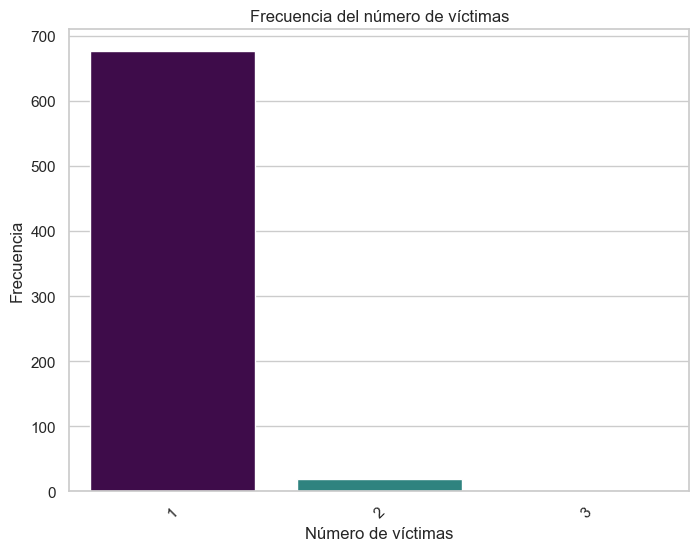

In [123]:
# Gráfico de frecuencia de 'num_victimas'
plt.figure(figsize=(8, 6))
sns.countplot(x='N_VICTIMAS', data=dfsiniestros, hue='N_VICTIMAS', palette='viridis', legend=False)


plt.title('Frecuencia del número de víctimas')
plt.xlabel('Número de víctimas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

#### Columnas relativas a la fecha
Se renombran algunas columnas para facilitar la lectura. En el DF original, las fechas estaban separadas por mes año y día, además de contar con una columna con las fechas completas. Por esta razón se quiso verificar que coincida la columna FECHA con las restantes. También se corrobora que los tipos de datos esten en un formato adecuado para su posterior uso.

In [124]:
dfsiniestros.rename(columns={'AAAA': 'AÑO', 'MM': 'MES', 'DD': 'DIA'}, inplace=True)


In [125]:
# Verificar que cada fila coincida
dfsiniestros['coincide'] = (dfsiniestros['FECHA'].dt.year == dfsiniestros['AÑO']) & \
                 (dfsiniestros['FECHA'].dt.month == dfsiniestros['MES']) & \
                 (dfsiniestros['FECHA'].dt.day == dfsiniestros['DIA'])

filas_incorrectas = dfsiniestros[dfsiniestros['coincide'] == False]

# Mostrar solo esas filas
print(filas_incorrectas)

           ID  N_VICTIMAS      FECHA   AÑO  MES  DIA      HORA HH  \
64  2016-0087           1 2016-07-02  2016    7    3  00:10:00  0   

                                     LUGAR_DEL_HECHO TIPO_DE_CALLE  ... Cruce  \
64  AUTOPISTA 1 SUR PTE ARTURO FRONDIZI Y AV CASEROS     AUTOPISTA  ...   NaN   

                                Dirección Normalizada COMUNA  \
64  AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI y C...      1   

                                  XY (CABA)         pos x         pos y  \
64  Point (107762.62066736 100018.90176187)  -58.37864583  -34.62907067   

       PARTICIPANTES VICTIMA      ACUSADO coincide  
64  MOTO-OBJETO FIJO    MOTO  OBJETO FIJO    False  

[1 rows x 22 columns]


In [126]:
#Se cambia la fecha que no coincidió
dfsiniestros.loc[dfsiniestros['ID'] == '2016-0087', 'DIA'] = 2


In [127]:
dfsiniestros['HORA'] = pd.to_datetime(dfsiniestros['HORA'], format='%H:%M:%S', errors='coerce')


dfsiniestros['HORA'] = dfsiniestros['HORA'].dt.time

print(dfsiniestros['HORA'].head())

dfsiniestros['HH'] = pd.to_numeric(dfsiniestros['HH'], errors='coerce').astype('Int64')


0    04:00:00
1    01:15:00
2    07:00:00
3    00:00:00
4    05:20:00
Name: HORA, dtype: object


Podemos ver que de los datos con los que contamos, el año donde más accidentes ocurrieron fue 2016. El año con menos accidentes registrados fue 2020, lo que podemos concluir en una primera instancia que fue debido a una menor circulación de vehículos por la pandemia del COVID.

In [128]:
# Cuadro con suma de accidentes por año
frecuencia_años = dfsiniestros['AÑO'].value_counts().sort_index()

cuadro_frecuencia_años = pd.DataFrame({
    'Año': frecuencia_años.index,
    'Cantidad': frecuencia_años.values
})

from IPython.display import display
display(cuadro_frecuencia_años)


,Año,Cantidad
0,2016,144
1,2017,131
2,2018,143
3,2019,103
4,2020,78
5,2021,97


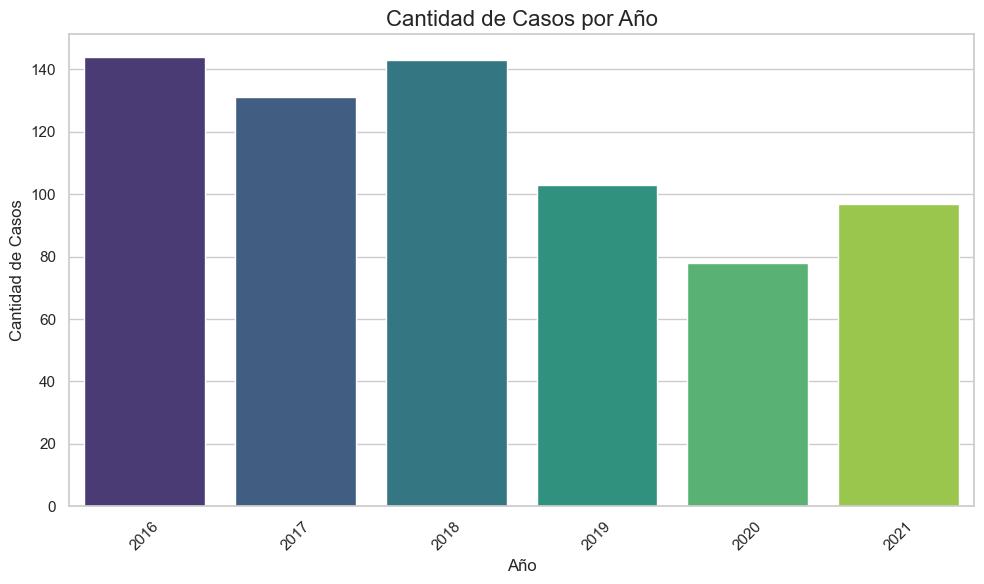

In [129]:
plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencia_años.index, y=frecuencia_años.values, palette="viridis")

plt.title('Cantidad de Casos por Año', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Casos', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Se hizo una matriz de gráficos donde se comparó cantidad de accidentes por año, mes, día y hora

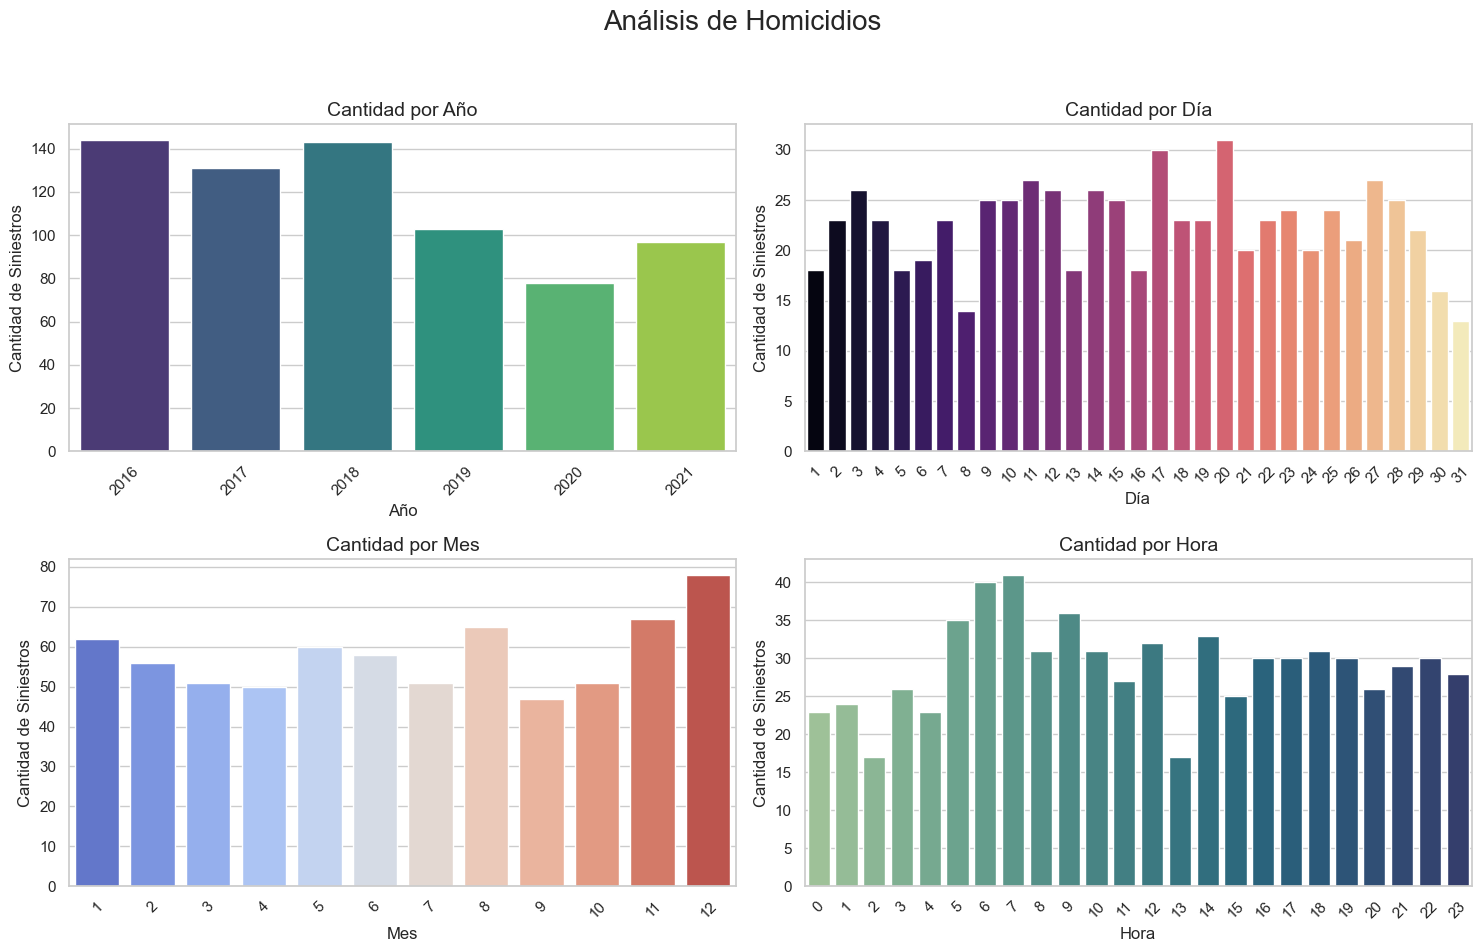

In [130]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  
fig.suptitle('Análisis de Homicidios', fontsize=20)

# Gráfico 1: Cantidad por Año
frecuencia_anios = dfsiniestros['AÑO'].value_counts().sort_index()
sns.barplot(x=frecuencia_anios.index, y=frecuencia_anios.values, palette="viridis", ax=axs[0, 0])
axs[0, 0].set_title('Cantidad por Año', fontsize=14)
axs[0, 0].set_xlabel('Año', fontsize=12)
axs[0, 0].set_ylabel('Cantidad de Siniestros', fontsize=12)
axs[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: Cantidad por Día
frecuencia_dias = dfsiniestros['DIA'].value_counts().sort_index()
sns.barplot(x=frecuencia_dias.index, y=frecuencia_dias.values, palette="magma", ax=axs[0, 1])
axs[0, 1].set_title('Cantidad por Día', fontsize=14)
axs[0, 1].set_xlabel('Día', fontsize=12)
axs[0, 1].set_ylabel('Cantidad de Siniestros', fontsize=12)
axs[0, 1].tick_params(axis='x', rotation=45)

# Gráfico 3: Cantidad por Mes
frecuencia_meses = dfsiniestros['MES'].value_counts().sort_index()
sns.barplot(x=frecuencia_meses.index, y=frecuencia_meses.values, palette="coolwarm", ax=axs[1, 0])
axs[1, 0].set_title('Cantidad por Mes', fontsize=14)
axs[1, 0].set_xlabel('Mes', fontsize=12)
axs[1, 0].set_ylabel('Cantidad de Siniestros', fontsize=12)
axs[1, 0].tick_params(axis='x', rotation=45)

# Gráfico 4: Cantidad por Hora
frecuencia_horas = dfsiniestros['HH'].value_counts().sort_index()
sns.barplot(x=frecuencia_horas.index, y=frecuencia_horas.values, palette="crest", ax=axs[1, 1])
axs[1, 1].set_title('Cantidad por Hora', fontsize=14)
axs[1, 1].set_xlabel('Hora', fontsize=12)
axs[1, 1].set_ylabel('Cantidad de Siniestros', fontsize=12)
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar el espacio para el título
plt.show()

Como conclusión podemos decir que:
+ El año con mayor accidentes fue 2016
+ El día del mes que cuenta con mayores registros fue el 20
+ El mes de diciembre tiene más siniestros, lo que puede deberse a la época del año donde coincide el comienzo de las vacaciones escolares y las fiestas de fin de año.
+ El horario con más accidentes registrados fue a las 7 de la mañana, lo que puede deberse a que las personas se movilizan para ir a trabajar, por ende una mayor circulación de vehículos.

#### Columnas relativas a la dirección

Aquí podemos ver que se presentan columnas redundantes, al no ser un set de datos extremadamente grande, por seguridad no se descartan. Pero se comprueba si tienen la misma información, y se trata de normalizar los caracteres extraños que pueden dar error en futuros análisis. También se agregó a modo informativo los nombres de las comunas.

In [131]:
dfsiniestros.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AÑO', 'MES', 'DIA', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO', 'coincide'],
      dtype='object')

In [132]:
print(dfsiniestros[['LUGAR_DEL_HECHO', 'Dirección Normalizada']])


                               LUGAR_DEL_HECHO  \
0    AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ   
1            AV GRAL PAZ  Y AV DE LOS CORRALES   
2                           AV ENTRE RIOS 2034   
3        AV LARRAZABAL Y GRAL VILLEGAS CONRADO   
4    AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA    
..                                         ...   
691                          AV. RIESTRA Y MOM   
692                    AU DELLEPIANE Y LACARRA   
693                        AV. GAONA Y TERRADA   
694                         AV. EVA PERON 4071   
695                    PADRE CARLOS MUJICA 709   

                                 Dirección Normalizada  
0    PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...  
1                 PAZ, GRAL. AV. y DE LOS CORRALES AV.  
2                                  ENTRE RIOS AV. 2034  
3            LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.  
4              SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.  
..                                                 ...  


In [133]:
# Verificar valores nulos en las columnas
print(dfsiniestros['LUGAR_DEL_HECHO'].isnull().sum())
print(dfsiniestros['Dirección Normalizada'].isnull().sum())

0
8


In [134]:
dfsiniestros['Dirección Normalizada'] = dfsiniestros['Dirección Normalizada'].fillna(dfsiniestros['LUGAR_DEL_HECHO'])


In [135]:
def comparar_strings(row):
    return fuzz.ratio(row['LUGAR_DEL_HECHO'], row['Dirección Normalizada'])

dfsiniestros['similaridad'] = dfsiniestros.apply(comparar_strings, axis=1)

# Ver filas con alta similitud
similares = dfsiniestros[dfsiniestros['similaridad'] > 50]  
print(similares)
diferentes = dfsiniestros[dfsiniestros['similaridad'] < 50]
muydif = dfsiniestros[dfsiniestros['similaridad'] < 20]

            ID  N_VICTIMAS      FECHA   AÑO  MES  DIA      HORA  HH  \
0    2016-0001           1 2016-01-01  2016    1    1  04:00:00   4   
1    2016-0002           1 2016-01-02  2016    1    2  01:15:00   1   
2    2016-0003           1 2016-01-03  2016    1    3  07:00:00   7   
3    2016-0004           1 2016-01-10  2016    1   10  00:00:00   0   
4    2016-0005           1 2016-01-21  2016    1   21  05:20:00   5   
..         ...         ...        ...   ...  ...  ...       ...  ..   
691  2021-0093           1 2021-12-13  2021   12   13  17:10:00  17   
692  2021-0094           1 2021-12-20  2021   12   20  01:10:00   1   
693  2021-0095           1 2021-12-30  2021   12   30  00:43:00   0   
694  2021-0096           1 2021-12-15  2021   12   15  10:30:00  10   
695  2021-0097           1 2021-11-18  2021   11   18  06:10:00   6   

                               LUGAR_DEL_HECHO TIPO_DE_CALLE  ...  \
0    AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ       AVENIDA  ...   
1        

In [136]:
muydif[['LUGAR_DEL_HECHO','Dirección Normalizada']]

,LUGAR_DEL_HECHO,Dirección Normalizada
346,"AU Dellepiane kilometro 0.0, altura calle Mont...",AUTOPISTA DELLEPIANE LUIS TTE. GRAL. y MONTIEL
377,Av. Castañares y Bonorino,"CASTAÃ‘ARES AV. y BONORINO, ESTEBAN, CNEL. AV."


In [137]:
def corregir_errores_especificos(texto):
    if isinstance(texto, str):  
        texto = texto.replace("Ã‘", "Ñ")  
        texto = texto.replace("Ã", "Á")  
        texto = texto.replace("â", "á")  
        texto = texto.replace("â", "-")  
        texto = texto.replace("â", "“")  
        texto = texto.replace("â", "”")
        texto = texto.replace('�','Ñ') 
    return texto

# Aplicamos la función a la columna donde están los errores
dfsiniestros['LUGAR_DEL_HECHO'] = dfsiniestros['LUGAR_DEL_HECHO'].apply(corregir_errores_especificos)
dfsiniestros['Dirección Normalizada'] = dfsiniestros['Dirección Normalizada'].apply(corregir_errores_especificos)
dfsiniestros['Cruce'] = dfsiniestros['Dirección Normalizada'].apply(corregir_errores_especificos)

# Verificamos de nuevo los resultados
dfsiniestros.head(10)

,ID,N_VICTIMAS,FECHA,AÑO,MES,DIA,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,coincide,similaridad
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,True,76
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,True,72
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,True,81
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD,True,74
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,"SAN JUAN AV. y SAENZ PEÑA, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS,True,55
5,2016-0008,1,2016-01-24,2016,1,24,18:30:00,18,AV 27 DE FEBRERO Y AV ESCALADA,AVENIDA,...,27 DE FEBRERO AV. y ESCALADA AV.,8,Point (101721.59002217 93844.25656649),-58.44451316,-34.68475866,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO,True,81
6,2016-0009,1,2016-01-24,2016,1,24,19:10:00,19,NOGOYA Y JOAQUIN V. GONZALES,CALLE,...,"NOGOYA y GONZALEZ, JOAQUIN V.",11,Point (96545.87592078 102330.67262199),-58.50095869,-34.60825440,MOTO-AUTO,MOTO,AUTO,True,63
7,2016-0010,1,2016-01-29,2016,1,29,15:20:00,15,AV GENERAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,MOTO-AUTO,MOTO,AUTO,True,70
8,2016-0012,1,2016-02-08,2016,2,8,01:20:00,1,AV BELGRANO Y BERNARDO DE IRIGOYEN,AVENIDA,...,"BELGRANO AV. e IRIGOYEN, BERNARDO DE",1,Point (107595.35084333 101797.50052813),-58.38048577,-34.61303893,MOTO-CARGAS,MOTO,CARGAS,True,63
9,2016-0013,1,2016-02-10,2016,2,10,11:30:00,11,AV ENTRE RIOS 1366,AVENIDA,...,ENTRE RIOS AV. 1366,1,Point (106616.41069662 100496.44662323),-58.39114932,-34.62477387,PEATON-AUTO,PEATON,AUTO,True,81


Lo que puedo inferir de hacer esta combinación, es que GRAL PAZ es una avenida, y cuando se normalizaron los datos al quedar PAZ, GRAL, la función la tomo como tipo de calle directamente, por lo que me parece sensato cambiar GRAL PAZ a AVENIDA.


In [138]:
resultado = dfsiniestros[dfsiniestros['TIPO_DE_CALLE'] == 'GRAL PAZ'][['Dirección Normalizada']]


In [139]:
resultado

,Dirección Normalizada
1,"PAZ, GRAL. AV. y DE LOS CORRALES AV."
7,"PAZ, GRAL. AV. y DE LOS CORRALES AV."
17,"PAZ, GRAL. AV. y 27 DE FEBRERO AV."
22,"PAZ, GRAL. AV. y ROCA, CNEL. AV."
27,"PAZ, GRAL. AV. y ZUVIRIA"
...,...
650,"PAZ, GRAL. AV. 14723"
656,"PAZ, GRAL. AV. y VEDIA"
662,"PAZ, GRAL. AV. y TONELERO"
672,"PAZ, GRAL. AV. y BALBIN, RICARDO, DR. AV."


In [140]:
# Reemplazar 'GRAL PAZ' con 'AVENIDA' en la columna 'TIPO_DE_CALLE'
dfsiniestros['TIPO_DE_CALLE'] = dfsiniestros['TIPO_DE_CALLE'].replace('GRAL PAZ', 'AVENIDA')

# Verificar si se realizaron los cambios
print(dfsiniestros['TIPO_DE_CALLE'].unique())

['AVENIDA' 'CALLE' 'AUTOPISTA']


TIPO_DE_CALLE
AVENIDA      494
CALLE        136
AUTOPISTA     66
Name: count, dtype: int64


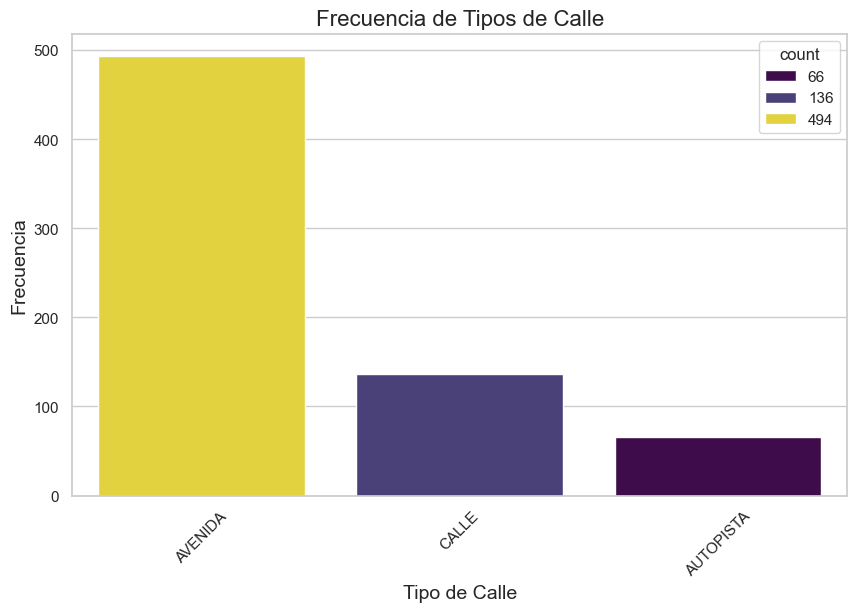

In [141]:
# Contar las frecuencias de 'TIPO_DE_CALLE'
frecuencias = dfsiniestros['TIPO_DE_CALLE'].value_counts()

# Imprimir las frecuencias
print(frecuencias)

# Graficar las frecuencias
plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencias.index, y=frecuencias.values, hue = frecuencias ,palette='viridis')
plt.title('Frecuencia de Tipos de Calle', fontsize=16)
plt.xlabel('Tipo de Calle', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas en el eje x si es necesario
plt.show()

Claramente podemos ver que la mayoría de accidentes ocurren en el tipo de calle AVENIDA.

In [142]:
mapeo_comunas = {
    1: 'Retiro, San Nicolás, Puerto Madero, San Telmo, Montserrat y Constitución.',
    2: 'Recoleta',
    3: 'Balvanera y San Cristóbal',
    4: 'La Boca, Barracas, Parque Patricios y Nueva Pompeya',
    5: 'Almagro y Boedo',
    6: 'Caballito',
    7: 'Flores y Parque Chacabuco',
    8: 'Villa Soldati, Villa Riachuelo y Villa Lugano',
    9: 'Liniers, Mataderos y Parque Avellaneda',
    10: 'Villa Real, Monte Castro, Versalles, Floresta, Vélez Sarsfield y Villa Luro',
    11: 'Villa General Mitre, Villa Devoto, Villa del Parque y Villa Santa Rita',
    12: 'Coghlan, Saavedra, Villa Urquiza y Villa Pueyrredón',
    13: 'Núñez, Belgrano y Colegiales',
    14: 'Palermo',
    15: 'Chacarita, Villa Crespo, La Paternal, Villa Ortúzar, Agronomía y Parque Chas'
}

# Reemplazar los números de la columna 'COMUNA' por sus nombres usando el diccionario
dfsiniestros['NOMBRE_COMUNA'] = dfsiniestros['COMUNA'].map(mapeo_comunas)

# Mostrar el resultado
dfsiniestros


,ID,N_VICTIMAS,FECHA,AÑO,MES,DIA,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,coincide,similaridad,NOMBRE_COMUNA
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,True,76,"Villa Soldati, Villa Riachuelo y Villa Lugano"
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,AVENIDA,...,9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,True,72,"Liniers, Mataderos y Parque Avellaneda"
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,True,81,"Retiro, San Nicolás, Puerto Madero, San Telmo,..."
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD,True,74,"Villa Soldati, Villa Riachuelo y Villa Lugano"
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS,True,55,"Retiro, San Nicolás, Puerto Madero, San Telmo,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2021-0093,1,2021-12-13,2021,12,13,17:10:00,17,AV. RIESTRA Y MOM,AVENIDA,...,7,Point (102728.60090138 98186.24929177),-58.43353773,-34.64561636,MOTO-AUTO,MOTO,AUTO,True,71,Flores y Parque Chacabuco
692,2021-0094,1,2021-12-20,2021,12,20,01:10:00,1,AU DELLEPIANE Y LACARRA,AUTOPISTA,...,9,Point (99624.29795829 97569.69801131),-58.46739825,-34.65117757,MOTO-AUTO,MOTO,AUTO,True,58,"Liniers, Mataderos y Parque Avellaneda"
693,2021-0095,1,2021-12-30,2021,12,30,00:43:00,0,AV. GAONA Y TERRADA,AVENIDA,...,11,Point (99116.45492358 101045.23284826),-58.47293407,-34.61984745,MOTO-CARGAS,MOTO,CARGAS,True,74,"Villa General Mitre, Villa Devoto, Villa del P..."
694,2021-0096,1,2021-12-15,2021,12,15,10:30:00,10,AV. EVA PERON 4071,AVENIDA,...,9,Point (99324.54463985 97676.26932409),-58.47066794,-34.65021673,AUTO-CARGAS,AUTO,CARGAS,True,54,"Liniers, Mataderos y Parque Avellaneda"


In [143]:
# Crear una tabla de frecuencias para la columna 'COMUNA'
tabla_frecuencias = dfsiniestros['COMUNA'].value_counts()

# Convertir a DataFrame y renombrar las columnas
tabla_frecuencias = tabla_frecuencias.reset_index()
tabla_frecuencias.columns = ['COMUNA', 'FRECUENCIA']

# Imprimir la tabla de frecuencias
print(tabla_frecuencias)


    COMUNA  FRECUENCIA
0        1          90
1        4          76
2        9          73
3        8          65
4        7          60
5        3          45
6       15          44
7       13          40
8       12          37
9       14          35
10      11          32
11      10          29
12       2          25
13       5          22
14       6          21
15       0           2


Vemos que tenemos dos filas donde las comunas son cero, filtramos para saber mas información y vemos que tenemos algunos datos, como fecha y una victima, pero algunos datos nulos. Por el momento la dejamos porque son solo dos datos, pero al graficar, la excluimos para no generar confusiones.

In [144]:
comunas_cero = dfsiniestros[dfsiniestros['COMUNA'] == 0]
print(comunas_cero)

            ID  N_VICTIMAS      FECHA   AÑO  MES  DIA      HORA  HH  \
119  2016-0151           1 2016-11-18  2016   11   18  20:35:00  20   
139  2016-0174           1 2016-12-27  2016   12   27  00:00:00   0   

          LUGAR_DEL_HECHO TIPO_DE_CALLE  ... COMUNA    XY (CABA) pos x pos y  \
119                    SD         CALLE  ...      0  Point (. .)     .     .   
139  AUTOPISTA 25 DE MAYO     AUTOPISTA  ...      0  Point (. .)     .     .   

     PARTICIPANTES VICTIMA ACUSADO coincide similaridad NOMBRE_COMUNA  
119      PEATON-SD  PEATON      SD     True         100           NaN  
139          SD-SD      SD      SD     True         100           NaN  

[2 rows x 24 columns]


In [145]:
tabla_frecuencias = tabla_frecuencias[tabla_frecuencias['COMUNA'] != 0]


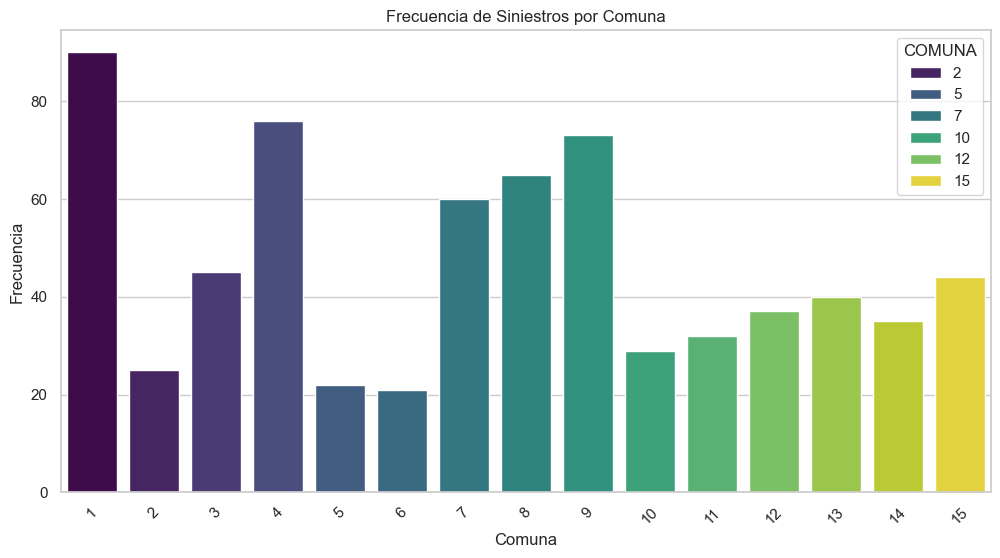

In [146]:
# Graficar la tabla de frecuencias
plt.figure(figsize=(12, 6))
sns.barplot(x='COMUNA', y='FRECUENCIA', data=tabla_frecuencias, palette='viridis', hue = 'COMUNA')
plt.title('Frecuencia de Siniestros por Comuna')
plt.xlabel('Comuna')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


Buscando más información, se llego a la conclusión de dejarla por seguridad, pero en el dataframe ya contamos con las coordenadas en formato normal.

In [147]:
dfsiniestros['XY (CABA)']

0        Point (98896.78238426 93532.43437792)
1        Point (95832.05571093 95505.41641999)
2       Point (106684.29090040 99706.57687843)
3        Point (99840.65224780 94269.16534422)
4      Point (106980.32827929 100752.16915795)
                        ...                   
691     Point (102728.60090138 98186.24929177)
692      Point (99624.29795829 97569.69801131)
693     Point (99116.45492358 101045.23284826)
694      Point (99324.54463985 97676.26932409)
695    Point (107664.16647795 104708.63962087)
Name: XY (CABA), Length: 696, dtype: object

In [148]:
dfsiniestros[['pos x','pos y']].isnull().sum()

pos x    0
pos y    0
dtype: int64

In [149]:
dfsiniestros.rename(columns={'pos x': 'longitud', 'pos y': 'latitud'}, inplace=True)
print(dfsiniestros.columns)


Index(['ID', 'N_VICTIMAS', 'FECHA', 'AÑO', 'MES', 'DIA', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'longitud', 'latitud',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO', 'coincide', 'similaridad',
       'NOMBRE_COMUNA'],
      dtype='object')


In [150]:
dfsiniestros[['longitud','latitud']].dtypes

longitud    object
latitud     object
dtype: object

In [151]:
dfsiniestros['longitud'].replace('.', np.nan, inplace=True)
dfsiniestros['latitud'].replace('.', np.nan, inplace=True)

In [152]:
# Convertir a float
dfsiniestros['longitud'] = dfsiniestros['longitud'].astype(float)
dfsiniestros['latitud'] = dfsiniestros['latitud'].astype(float)

#### Columnas sobre los involucrados

Al igual que con las otras columnas, se chequean valores únicos, anomalías, y se acomodan para que coincidan.
A la vez se corrobora que todos las categorías que se presentan en el DF estén explicadas en el PDF del gobierno, corroborando que tengan coherencia. Por ejemplo, se pudo ver que en la columna ACUSADO, se repetía PASAJEROS, lo que se toma como un ROL y no como acusado. A su vez, no se encontraban datos de transporte público, por lo que se infirió que PASAJEROS en la columna ACUSADO, se refería a TRANSPORTE PÚBLICO.

In [153]:
print(dfsiniestros['PARTICIPANTES'].unique())
print(dfsiniestros['VICTIMA'].unique())
print(dfsiniestros['ACUSADO'].unique())

['MOTO-AUTO' 'AUTO-PASAJEROS' 'MOTO-SD' 'MOTO-PASAJEROS'
 'MOTO-OBJETO FIJO' 'MOTO-CARGAS' 'PEATON-AUTO' 'PEATON-MOTO'
 'PEATON-PASAJEROS' 'AUTO-AUTO' 'AUTO-OBJETO FIJO' 'PEATON-CARGAS'
 'MOTO-MOTO' 'MULTIPLE' 'SD-SD' 'AUTO-CARGAS' 'AUTO-SD' 'MOTO-MOVIL'
 'CARGAS-CARGAS' 'PEATON-SD' 'BICICLETA-CARGAS' 'SD-CARGAS'
 'BICICLETA-PASAJEROS' 'PASAJEROS-PASAJEROS' 'MOVIL-PASAJEROS'
 'CARGAS-OBJETO FIJO' 'PEATON-BICICLETA' 'SD-AUTO' 'CARGAS-AUTO'
 'BICICLETA-AUTO' 'MOTO-BICICLETA' 'SD-MOTO' 'MOVIL-CARGAS'
 'PASAJEROS-AUTO' 'AUTO-MOVIL' 'CARGAS-PASAJEROS' 'BICICLETA-TREN'
 'BICICLETA-OTRO' 'MOTO-OTRO' 'PEATON_MOTO-MOTO' 'PASAJEROS-SD']
['MOTO' 'AUTO' 'PEATON' 'SD' 'CARGAS' 'BICICLETA' 'PASAJEROS' 'MOVIL'
 'OBJETO FIJO' 'PEATON_MOTO']
['AUTO' 'PASAJEROS' 'SD' 'OBJETO FIJO' 'CARGAS' 'MOTO' 'MULTIPLE' 'OTRO'
 'BICICLETA' 'TREN']


In [154]:
# Reemplazar 'PASAJEROS' por 'TRANSPORTE PUBLICO' en la columna 'ACUSADO'
dfsiniestros['ACUSADO'] = dfsiniestros['ACUSADO'].replace('PASAJEROS', 'TRANSPORTE PUBLICO')
# Mostrar las filas actualizadas para verificar
print(dfsiniestros[dfsiniestros['ACUSADO'] == 'TRANSPORTE PUBLICO'][['PARTICIPANTES', 'VICTIMA', 'ACUSADO']])


        PARTICIPANTES VICTIMA             ACUSADO
1      AUTO-PASAJEROS    AUTO  TRANSPORTE PUBLICO
4      MOTO-PASAJEROS    MOTO  TRANSPORTE PUBLICO
13   PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
21   PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
22     MOTO-PASAJEROS    MOTO  TRANSPORTE PUBLICO
..                ...     ...                 ...
663  PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
664  PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
676    MOTO-PASAJEROS    MOTO  TRANSPORTE PUBLICO
684  PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
688  PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO

[173 rows x 3 columns]


In [155]:
dfsiniestros[['PARTICIPANTES','ACUSADO','VICTIMA']]

,PARTICIPANTES,ACUSADO,VICTIMA
0,MOTO-AUTO,AUTO,MOTO
1,AUTO-PASAJEROS,TRANSPORTE PUBLICO,AUTO
2,MOTO-AUTO,AUTO,MOTO
3,MOTO-SD,SD,MOTO
4,MOTO-PASAJEROS,TRANSPORTE PUBLICO,MOTO
...,...,...,...
691,MOTO-AUTO,AUTO,MOTO
692,MOTO-AUTO,AUTO,MOTO
693,MOTO-CARGAS,CARGAS,MOTO
694,AUTO-CARGAS,CARGAS,AUTO


In [156]:
dfsiniestros[['PARTICIPANTES','ACUSADO','VICTIMA']].isnull().sum()

PARTICIPANTES    0
ACUSADO          0
VICTIMA          0
dtype: int64

In [157]:
# Función para verificar si PARTICIPANTES contiene ambos elementos
def verificar_participantes(row):
    participantes = row['PARTICIPANTES']
    partes = participantes.split('-')
    return (partes[0] in dfsiniestros['VICTIMA'].values) and (partes[1] in dfsiniestros['ACUSADO'].values)

dfsiniestros['verificacion'] = dfsiniestros.apply(verificar_participantes, axis=1)

# Verificar si hay filas donde la verificación falló
filas_invalidas = dfsiniestros[~dfsiniestros['verificacion']]
print(f"Número de filas donde la verificación falló: {len(filas_invalidas)}")
print("Filas inválidas:")
print(filas_invalidas[['PARTICIPANTES', 'VICTIMA', 'ACUSADO']])

Número de filas donde la verificación falló: 193
Filas inválidas:
        PARTICIPANTES VICTIMA             ACUSADO
1      AUTO-PASAJEROS    AUTO  TRANSPORTE PUBLICO
4      MOTO-PASAJEROS    MOTO  TRANSPORTE PUBLICO
13   PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
21   PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
22     MOTO-PASAJEROS    MOTO  TRANSPORTE PUBLICO
..                ...     ...                 ...
664  PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
672          MULTIPLE    MOTO            MULTIPLE
676    MOTO-PASAJEROS    MOTO  TRANSPORTE PUBLICO
684  PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO
688  PEATON-PASAJEROS  PEATON  TRANSPORTE PUBLICO

[193 rows x 3 columns]


In [158]:
# Crear un diccionario para las actualizaciones específicas
actualizaciones = {
    62:  'MOTO-OTRO',
    333: 'MOTO-OTRO',
    371: 'AUTO-OTRO'
}

# Actualizar las filas especificadas
for index, nuevo_valor in actualizaciones.items():
    dfsiniestros.at[index, 'PARTICIPANTES'] = nuevo_valor

# Mostrar las filas actualizadas para verificar
filas_actualizadas = dfsiniestros.loc[list(actualizaciones.keys())]
print("Filas actualizadas:")
print(filas_actualizadas[['PARTICIPANTES', 'VICTIMA', 'ACUSADO']])


Filas actualizadas:
    PARTICIPANTES VICTIMA ACUSADO
62      MOTO-OTRO    MOTO    OTRO
333     MOTO-OTRO    MOTO    OTRO
371     AUTO-OTRO    AUTO    OTRO


In [159]:
# Reemplazar 'PASAJEROS' por 'TRANSPORTE PUBLICO' en la columna 'PARTICIPANTES'
dfsiniestros['PARTICIPANTES'] = dfsiniestros['PARTICIPANTES'].str.replace('PASAJEROS', 'TRANSPORTE PUBLICO')

# Mostrar las filas actualizadas para verificar
print(dfsiniestros[dfsiniestros['PARTICIPANTES'].str.contains('TRANSPORTE PUBLICO')][['PARTICIPANTES', 'VICTIMA', 'ACUSADO']])


                 PARTICIPANTES VICTIMA             ACUSADO
1      AUTO-TRANSPORTE PUBLICO    AUTO  TRANSPORTE PUBLICO
4      MOTO-TRANSPORTE PUBLICO    MOTO  TRANSPORTE PUBLICO
13   PEATON-TRANSPORTE PUBLICO  PEATON  TRANSPORTE PUBLICO
21   PEATON-TRANSPORTE PUBLICO  PEATON  TRANSPORTE PUBLICO
22     MOTO-TRANSPORTE PUBLICO    MOTO  TRANSPORTE PUBLICO
..                         ...     ...                 ...
663  PEATON-TRANSPORTE PUBLICO  PEATON  TRANSPORTE PUBLICO
664  PEATON-TRANSPORTE PUBLICO  PEATON  TRANSPORTE PUBLICO
676    MOTO-TRANSPORTE PUBLICO    MOTO  TRANSPORTE PUBLICO
684  PEATON-TRANSPORTE PUBLICO  PEATON  TRANSPORTE PUBLICO
688  PEATON-TRANSPORTE PUBLICO  PEATON  TRANSPORTE PUBLICO

[175 rows x 3 columns]


In [160]:
dfsiniestros['VICTIMA'] = dfsiniestros['VICTIMA'].str.replace('PASAJEROS', 'TRANSPORTE PUBLICO')


In [161]:
# Función para modificar el valor de PARTICIPANTES
def actualizar_participantes(row):
    if row['PARTICIPANTES'] == 'MULTIPLE':
        return f"{row['VICTIMA']}-MULTIPLE"
    return row['PARTICIPANTES']

# Aplicar la función al DataFrame
dfsiniestros['PARTICIPANTES'] = dfsiniestros.apply(actualizar_participantes, axis=1)

# Mostrar las filas actualizadas para verificar
filas_actualizadas = dfsiniestros[dfsiniestros['PARTICIPANTES'].str.contains('MULTIPLE')]
print("Filas actualizadas:")
print(filas_actualizadas[['PARTICIPANTES', 'VICTIMA', 'ACUSADO']])


Filas actualizadas:
          PARTICIPANTES    VICTIMA   ACUSADO
31        MOTO-MULTIPLE       MOTO  MULTIPLE
143     PEATON-MULTIPLE     PEATON  MULTIPLE
146     PEATON-MULTIPLE     PEATON  MULTIPLE
153       MOTO-MULTIPLE       MOTO  MULTIPLE
174       AUTO-MULTIPLE       AUTO  MULTIPLE
225     PEATON-MULTIPLE     PEATON  MULTIPLE
277     PEATON-MULTIPLE     PEATON  MULTIPLE
278       MOTO-MULTIPLE       MOTO  MULTIPLE
355     PEATON-MULTIPLE     PEATON  MULTIPLE
375       AUTO-MULTIPLE       AUTO  MULTIPLE
425       MOTO-MULTIPLE       MOTO  MULTIPLE
444  BICICLETA-MULTIPLE  BICICLETA  MULTIPLE
458       AUTO-MULTIPLE       AUTO  MULTIPLE
513       MOTO-MULTIPLE       MOTO  MULTIPLE
550       MOTO-MULTIPLE       MOTO  MULTIPLE
643       MOTO-MULTIPLE       MOTO  MULTIPLE
672       MOTO-MULTIPLE       MOTO  MULTIPLE


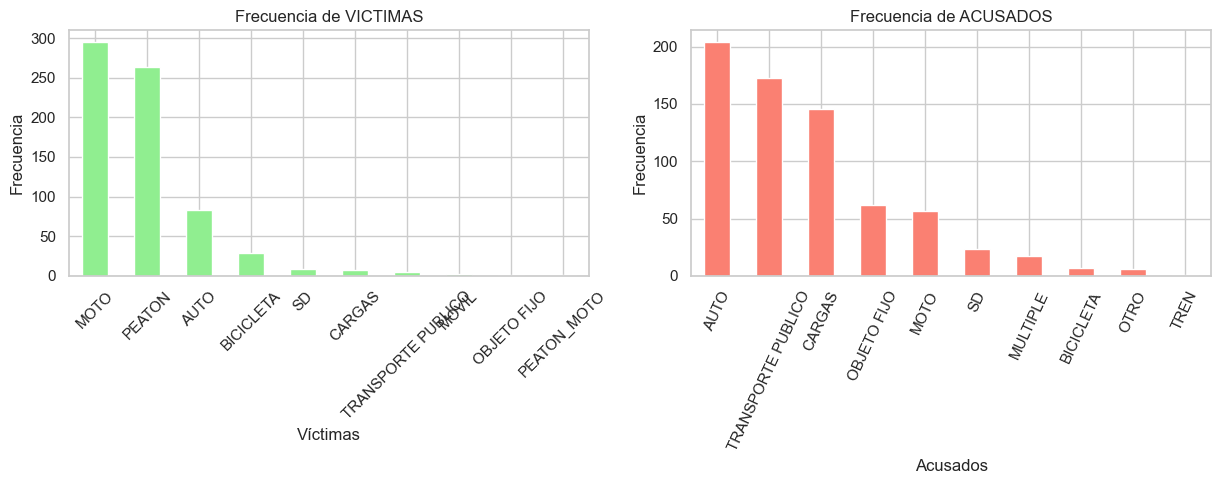

In [162]:
frecuencia_participantes = dfsiniestros['PARTICIPANTES'].value_counts().nlargest(10)
frecuencia_victima = dfsiniestros['VICTIMA'].value_counts()
frecuencia_acusado = dfsiniestros['ACUSADO'].value_counts()

# Graficos
plt.figure(figsize=(18, 5))

## Gráfico para VICTIMA
plt.subplot(1, 3, 2)
frecuencia_victima.plot(kind='bar', color='lightgreen')
plt.title('Frecuencia de VICTIMAS')
plt.xlabel('Víctimas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

## Gráfico para ACUSADO
plt.subplot(1, 3, 3)
frecuencia_acusado.plot(kind='bar', color='salmon')
plt.title('Frecuencia de ACUSADOS')
plt.xlabel('Acusados')
plt.ylabel('Frecuencia')
plt.xticks(rotation=65)


plt.tight_layout()
plt.show()


Las conclusiones que podemos sacar en base a este gráfico son:
+ Los vehículos en mayoría que son las víctimas del hecho son motos.
+ Los vehículos que más se presentan como la contraparte a la víctima son autos.

In [163]:
columnas_a_borrar = ['similaridad', 'coincide', 'verificacion']

dfsiniestros.drop(columns=columnas_a_borrar, axis=1, inplace=True)


### Exportación del archivo con los cambios

In [164]:
# Fin del análisis y exportación del DF con los cambios
dfsiniestros.to_excel('dfsiniestrosfinal.xlsx', index=False)



## Dataframe Víctimas

### Información primaria
Al igual que con el otro DataFrame, se buscan valores nulos y duplicados, además de verificarse los valores únicos. Se renombran las columnas para facilitar el uso.

In [165]:
dfvictimas.columns

Index(['ID_hecho', 'FECHA', 'AAAA', 'MM', 'DD', 'ROL', 'VICTIMA', 'SEXO',
       'EDAD', 'FECHA_FALLECIMIENTO'],
      dtype='object')

In [166]:
dfvictimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [167]:
dfvictimas.rename(columns={'AAAA': 'AÑO', 'MM': 'MES', 'DD': 'DIA'}, inplace=True)

In [168]:
dfvictimas['AÑO'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021])

In [169]:
dfvictimas['ID_hecho']

0      2016-0001
1      2016-0002
2      2016-0003
3      2016-0004
4      2016-0005
         ...    
712    2021-0092
713    2021-0093
714    2021-0094
715    2021-0095
716    2021-0096
Name: ID_hecho, Length: 717, dtype: object

In [170]:
dfvictimas['FECHA']

0     2016-01-01
1     2016-01-02
2     2016-01-03
3     2016-01-10
4     2016-01-21
         ...    
712   2021-12-12
713   2021-12-13
714   2021-12-20
715   2021-12-30
716   2021-12-15
Name: FECHA, Length: 717, dtype: datetime64[ns]

In [171]:
dfvictimas['MES'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [172]:
dfvictimas['DIA'].unique()

array([ 1,  2,  3, 10, 21, 24, 29,  8, 14, 15, 17, 28,  4, 12, 13, 19, 23,
       30, 31, 11, 20, 22, 25, 26, 16, 18, 27,  7,  9,  5,  6])

In [173]:
dfvictimas['ROL'].unique()

array(['CONDUCTOR', 'PASAJERO_ACOMPAÑANTE', 'PEATON', 'SD', 'CICLISTA'],
      dtype=object)

In [174]:
dfvictimas['SEXO'].unique()

array(['MASCULINO', 'FEMENINO', 'SD'], dtype=object)

In [175]:
dfvictimas['EDAD'].unique()



array([19, 70, 30, 18, 29, 22, 16, 59, 65, 34, 41, 50, 38, 21, 52, 36, 20,
       54, 'SD', 56, 24, 78, 79, 26, 57, 37, 58, 23, 60, 42, 53, 51, 40,
       87, 76, 75, 35, 80, 43, 45, 67, 27, 55, 49, 81, 25, 33, 46, 83, 39,
       28, 7, 48, 4, 82, 32, 17, 47, 61, 10, 95, 73, 84, 66, 85, 1, 15,
       13, 77, 44, 31, 62, 74, 71, 11, 86, 69, 72, 12, 63, 92, 68, 91, 64,
       5, 88], dtype=object)

#### Columna Edad
Al ser una columna importante a analizar, se decidió hacer una función para clasificar los datos en Rango Etario, esto facilitaría el posterior análisis.

In [206]:
# Reemplazar el valor 'SD' por NaN
dfvictimas['EDAD'] = dfvictimas['EDAD'].replace('SD', np.nan)

# Convertir la columna a numérica, con manejo de errores
dfvictimas['EDAD'] = pd.to_numeric(dfvictimas['EDAD'], errors='coerce')

Podemos concluir que el promedio de edad que presentan las víctimas al momento del hecho es de 42 años, el máximo de edad registrado fue de 95 años y el mínimo de 1 año de edad.

In [177]:
dfvictimas['EDAD'].describe()

count    664.000000
mean      42.167169
std       19.788034
min        1.000000
25%       27.000000
50%       37.000000
75%       56.250000
max       95.000000
Name: EDAD, dtype: float64

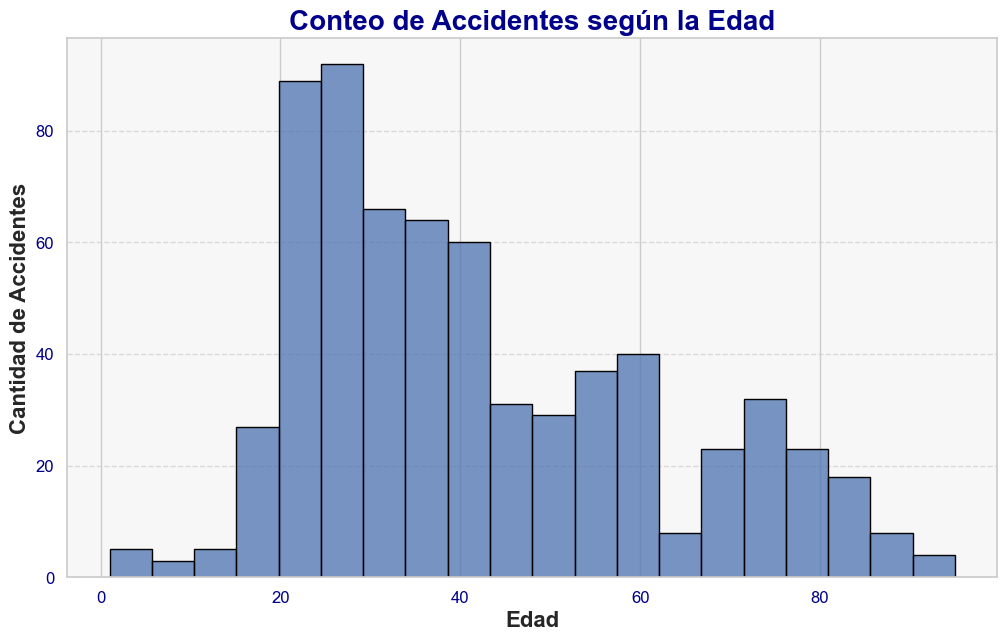

In [178]:
#Gráfico de accidentes según la edad

plt.figure(figsize=(12,7))

sns.histplot(dfvictimas['EDAD'].dropna(), bins=20, kde=False, 
             palette="husl", edgecolor='black')

plt.title('Conteo de Accidentes según la Edad', size=20, weight='bold', color='darkblue')
plt.xlabel('Edad', size=16, weight='bold')
plt.ylabel('Cantidad de Accidentes', size=16, weight='bold')
plt.xticks(size=12, color='darkblue')
plt.yticks(size=12, color='darkblue')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')

plt.show()

In [179]:
# Definir una función para clasificar la edad en rangos etarios
def clasificar_rango_etario(edad):
    if edad <= 10:
        return 'De 0 a 10 años'
    elif 10 <= edad <= 20:
        return 'De 10 a 20 años'
    elif 20 <= edad <= 30 :
        return 'De 20 a 30 años'
    elif 30 <= edad <= 40 :
        return 'De 30 a 45 años'
    elif 40 <= edad <= 50 :
        return 'De 45 a 60 años'
    elif edad >= 60:
        return 'Mayores de 60 años'
    else:
        return 'Desconocido'  # Para manejar NaN u otros valores no válidos

dfvictimas['Rango_Etario'] = dfvictimas['EDAD'].apply(clasificar_rango_etario)


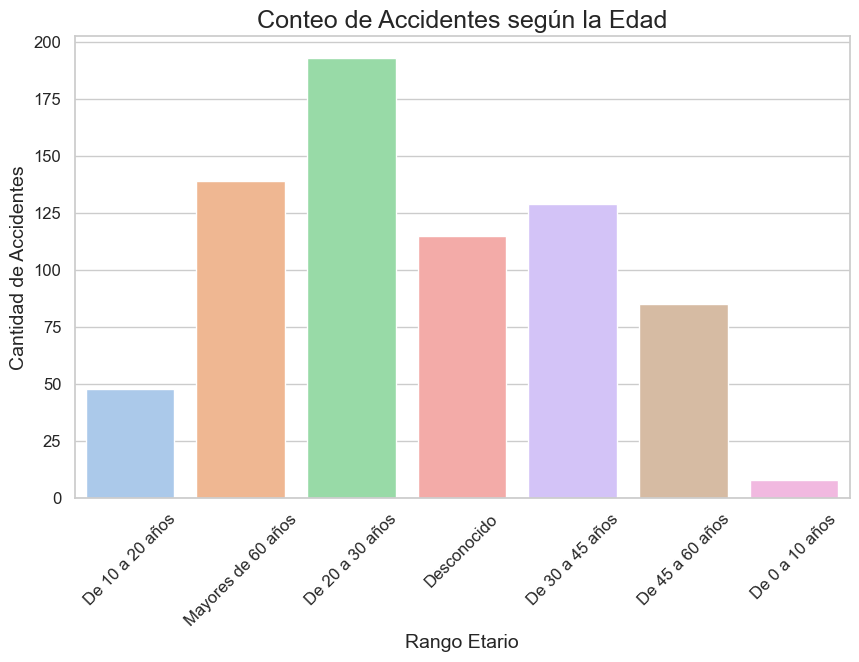

In [180]:
#Gráfico de hechos según el Rango Etario
plt.figure(figsize=(10, 6))

sns.countplot(x='Rango_Etario', data=dfvictimas, palette='pastel')

plt.title('Conteo de Accidentes según la Edad', size=18)
plt.xlabel('Rango Etario', size=14)
plt.ylabel('Cantidad de Accidentes', size=14)
plt.xticks(size=12, rotation=45)
plt.yticks(size=12)

plt.show()

Con este gráfico podemos concluir que la mayor cantidad de casos de víctimas tienen entre 20 a 30 años.

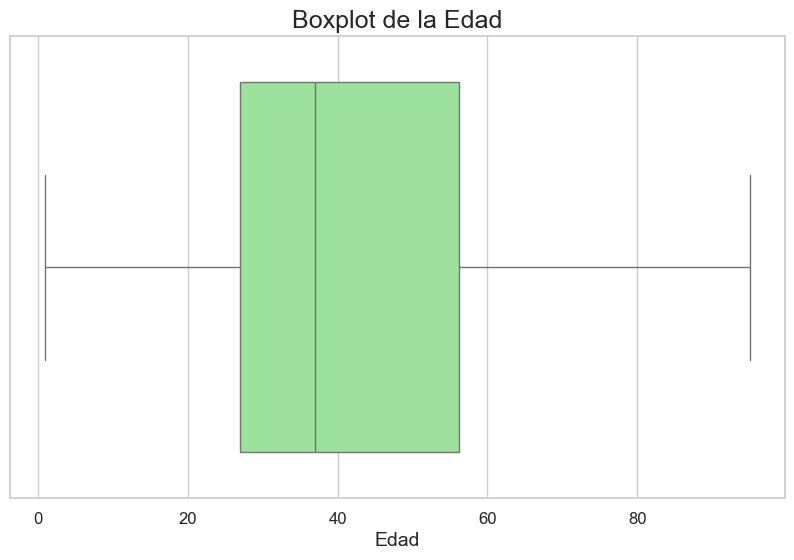

In [181]:
#Chequear outliers con un boxplot

plt.figure(figsize=(10, 6))
sns.boxplot(x=dfvictimas['EDAD'], color='lightgreen')
plt.title('Boxplot de la Edad', size=18)
plt.xlabel('Edad', size=14)
plt.xticks(size=12)

# Mostrar el gráfico
plt.show()


#### Columna Sexo de la víctima

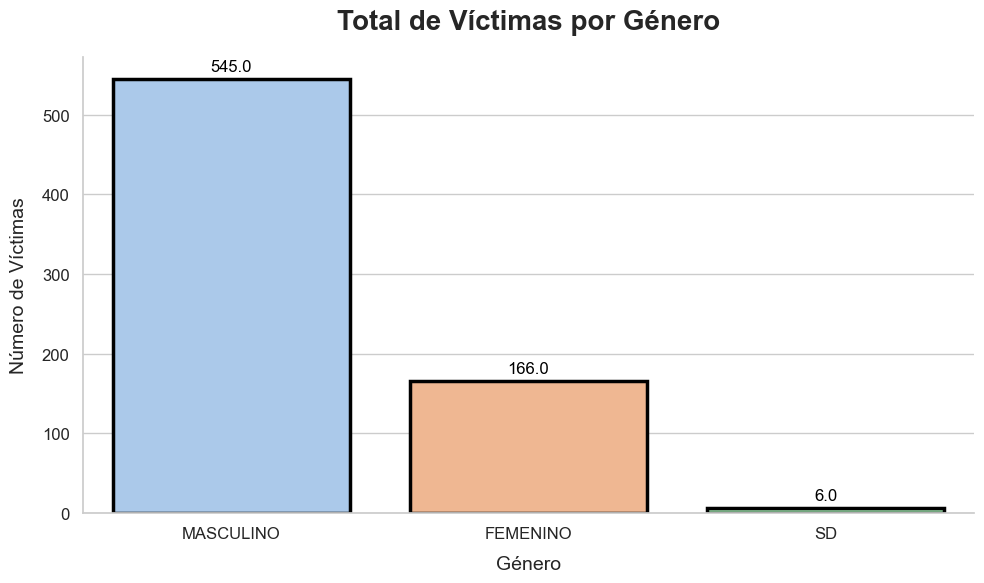

In [207]:
# Aplicar un estilo más elegante
sns.set_style("whitegrid")
sns.set_palette('pastel')

# Configurar el tamaño de la figura y otros parámetros
plt.figure(figsize=(10, 6))

# Crear el gráfico de conteo con barras más anchas y colores personalizados
ax = sns.countplot(x='SEXO', data=dfvictimas, linewidth=2.5, edgecolor='black', 
                   palette="pastel")

# Añadir etiquetas de conteo sobre las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12, color='black')

# Títulos y etiquetas
plt.title('Total de Víctimas por Género', size=20, weight='bold', pad=20)
plt.xlabel('Género', size=14, labelpad=10)
plt.ylabel('Número de Víctimas', size=14, labelpad=10)

# Mejorar los ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el formato de los ticks
plt.xticks(size=12)
plt.yticks(size=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Podemos concluir que existe una cantidad mayor significativa de víctimas masculinas que femeninas y tenemos seis datos que no se sabe el género.

#### Columna ROL de la víctima

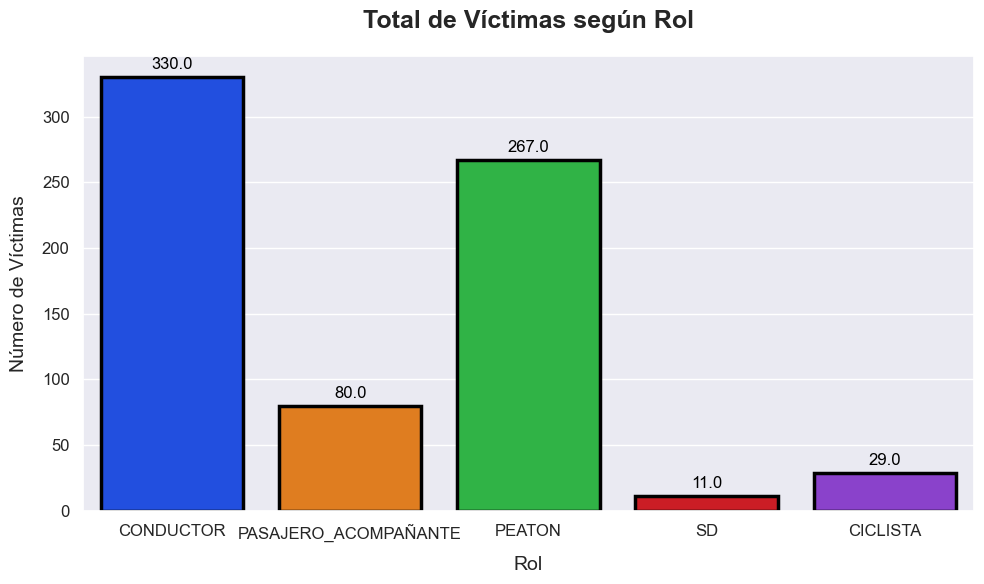

In [183]:
#Gráfico de total de víctimas según rol
sns.set_style("darkgrid")
sns.set_palette('pastel')

plt.figure(figsize=(10, 6))

ax = sns.countplot(x='ROL', data=dfvictimas, linewidth=2.5, edgecolor='black', 
                   palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12, color='black')

plt.title('Total de Víctimas según Rol', size=18, weight='bold', pad=20)
plt.xlabel('Rol', size=14, labelpad=10)
plt.ylabel('Número de Víctimas', size=14, labelpad=10)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.show()

La mayoría de los datos con los que contamos, son víctimas que eran conductores o peatones.

#### Columna vehículo de la víctima

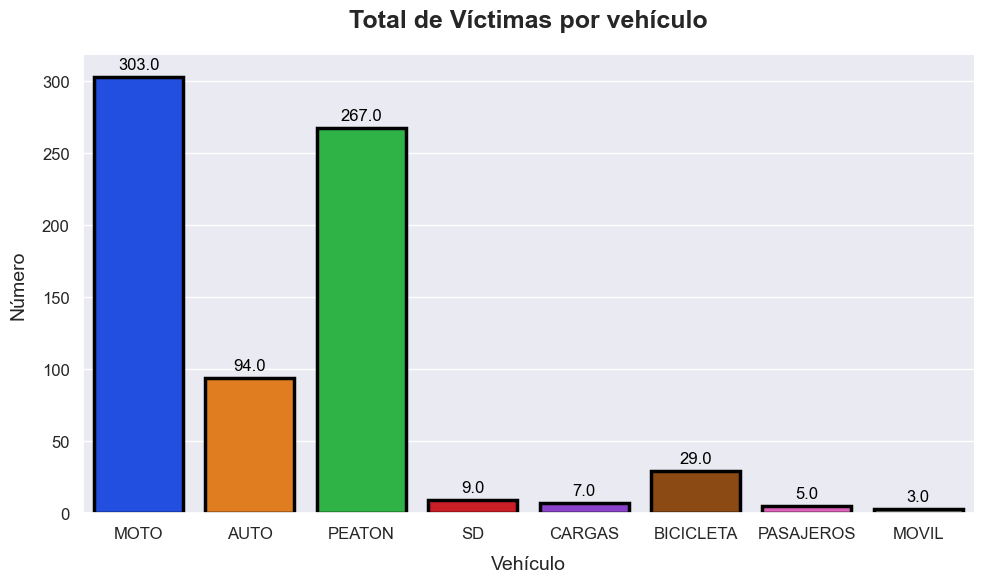

In [184]:
sns.set_style("darkgrid")
sns.set_palette('pastel')

plt.figure(figsize=(10, 6))

ax = sns.countplot(x='VICTIMA', data=dfvictimas, linewidth=2.5, edgecolor='black', 
                   palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12, color='black')

plt.title('Total de Víctimas por vehículo', size=18, weight='bold', pad=20)
plt.xlabel('Vehículo', size=14, labelpad=10)
plt.ylabel('Número', size=14, labelpad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.show()

Podemos observar que las motocicletas son el tipo de vehículo más frecuentemente registrado como involucrado en accidentes como víctimas.

#### Columnas relativas a fechas

Se hacen las mismas exploraciones que en el anterior data frame, esta vez con gráficos de lineas para poder visualizar mejor los picos y luego indagar más en ellos. También contamos con la fecha de fallecimiento de la víctima y se decidió hacer una comparación con el día del accidente.

In [185]:
# Asegurarse de que ambas columnas estén en formato datetime
dfvictimas['FECHA'] = pd.to_datetime(dfvictimas['FECHA'], errors='coerce')
dfvictimas['FECHA_FALLECIMIENTO'] = pd.to_datetime(dfvictimas['FECHA_FALLECIMIENTO'], errors='coerce')


In [186]:
dfvictimas['diferencia_dias'] = (dfvictimas['FECHA_FALLECIMIENTO'] - dfvictimas['FECHA']).dt.days


In [187]:
dfvictimas['diferencia_dias'].describe()

count    649.000000
mean       1.272727
std        3.780376
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       27.000000
Name: diferencia_dias, dtype: float64

Podemos ver que como promedio, las víctimas fallecen 1 día despues de la fecha del siniestro vial.

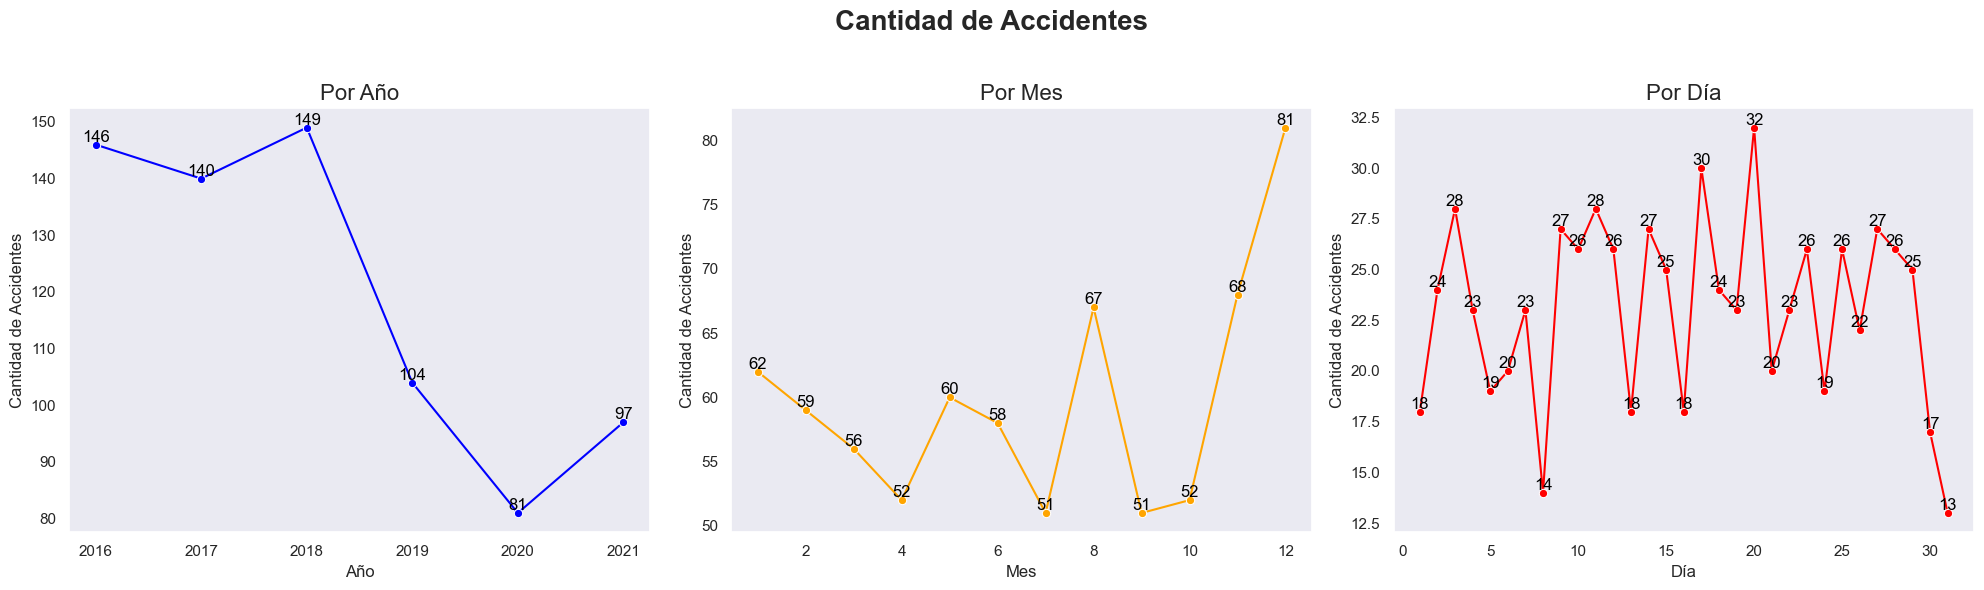

In [188]:
# Agrupar los datos por año, mes y día para crear graficos exploratorios
accidentes_por_año = dfvictimas['AÑO'].value_counts().sort_index()
accidentes_por_mes = dfvictimas['MES'].value_counts().sort_index()
accidentes_por_dia = dfvictimas['DIA'].value_counts().sort_index()

fig, axs = plt.subplots(1, 3, figsize=(20, 6))  
fig.suptitle('Cantidad de Accidentes', size=20, weight='bold')

# Gráfico por Año
sns.lineplot(ax=axs[0], x=accidentes_por_año.index, y=accidentes_por_año.values, marker='o', color='blue')
axs[0].set_title('Por Año', size=16)
axs[0].set_xlabel('Año', size=12)
axs[0].set_ylabel('Cantidad de Accidentes', size=12)
axs[0].grid()

for index, value in enumerate(accidentes_por_año.values):
    axs[0].text(accidentes_por_año.index[index], value, str(value), 
                color='black', ha='center', va='bottom')

# Gráfico por Mes
sns.lineplot(ax=axs[1], x=accidentes_por_mes.index, y=accidentes_por_mes.values, marker='o', color='orange')
axs[1].set_title('Por Mes', size=16)
axs[1].set_xlabel('Mes', size=12)
axs[1].set_ylabel('Cantidad de Accidentes', size=12)
axs[1].grid()

for index, value in enumerate(accidentes_por_mes.values):
    axs[1].text(accidentes_por_mes.index[index], value, str(value), 
                color='black', ha='center', va='bottom')

# Gráfico por Día
sns.lineplot(ax=axs[2], x=accidentes_por_dia.index, y=accidentes_por_dia.values, marker='o', color='red')
axs[2].set_title('Por Día', size=16)
axs[2].set_xlabel('Día', size=12)
axs[2].set_ylabel('Cantidad de Accidentes', size=12)
axs[2].grid()

for index, value in enumerate(accidentes_por_dia.values):
    axs[2].text(accidentes_por_dia.index[index], value, str(value), 
                color='black', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

Conclusiones en base a estos gráficos:
+ En 2018 se registraron 149 accidentes, siendo el máximo. Luego en 2019 bajó la cantidad, llegando a su pico mínimo en 2020 por los factores mencionados anteriormente.
+ El mes con más registros de accidentes es diciembre.
+ El día con más registros es el 20, pero no se puede observar un patrón segun la época del mes (principio o fin).

In [189]:
# Agrupar por año y mes, y contar la cantidad de accidentes
tabla_accidentes = dfvictimas.groupby(['AÑO', 'MES']).size().reset_index(name='Cantidad')

# Pivotar la tabla para que los meses sean columnas
tabla_pivot = tabla_accidentes.pivot(index='AÑO', columns='MES', values='Cantidad').fillna(0)


# Pivotar la tabla para que los meses sean columnas
tabla_pivot = tabla_accidentes.pivot(index='AÑO', columns='MES', values='Cantidad').fillna(0)

# Mostrar el DataFrame final
print(tabla_pivot)

MES   1   2   3   4   5   6   7   8   9   10  11  12
AÑO                                                 
2016   8  12  13  11   7  14  11  13  12  12  14  19
2017  10  11  12   9  18   9  12   9  13  11  14  12
2018  14  11   8  15  10  12  14  16   8  12  15  14
2019   9   8  11   9   9  11   5  14   9   6   8   5
2020   8   8   5   3   4   3   2   6   5   6   9  22
2021  13   9   7   5  12   9   7   9   4   5   8   9


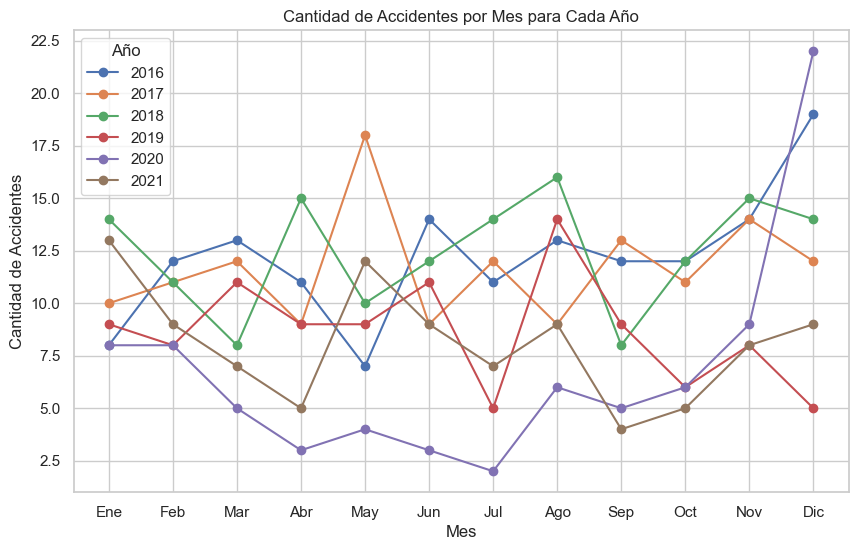

In [190]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))

for year in tabla_pivot.index:
    plt.plot(tabla_pivot.columns, tabla_pivot.loc[year], marker='o', label=year)

plt.title('Cantidad de Accidentes por Mes para Cada Año')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])  # Etiquetas de los meses

# Mostrar la leyenda
plt.legend(title='Año')

# Mostrar el gráfico
plt.show()


In [191]:
dfvictimas.to_excel('dfvictimasfinal.xlsx', index = False)

## Análisis bivariable

In [192]:
ruta_archivo = 'dfvictimasfinal.xlsx'
dfvictimas = pd.read_excel(ruta_archivo)
ruta2 = 'dfsiniestrosfinal.xlsx'
dfsiniestros = pd.read_excel(ruta2)

In [193]:
dfsiniestros.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AÑO', 'MES', 'DIA', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'longitud', 'latitud',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO', 'NOMBRE_COMUNA'],
      dtype='object')

In [194]:
dfvictimas.columns

Index(['ID_hecho', 'FECHA', 'AÑO', 'MES', 'DIA', 'ROL', 'VICTIMA', 'SEXO',
       'EDAD', 'FECHA_FALLECIMIENTO', 'Rango_Etario', 'diferencia_dias'],
      dtype='object')

In [195]:
columnas_dfvictimas = ['ID_hecho', 'SEXO', 'EDAD', 'Rango_Etario', 'ROL']

df_merged = pd.merge(dfsiniestros, dfvictimas[columnas_dfvictimas], left_on='ID', right_on='ID_hecho', how='inner')

print(df_merged.head())


          ID  N_VICTIMAS      FECHA   AÑO  MES  DIA      HORA   HH  \
0  2016-0001           1 2016-01-01  2016    1    1  04:00:00  4.0   
1  2016-0002           1 2016-01-02  2016    1    2  01:15:00  1.0   
2  2016-0003           1 2016-01-03  2016    1    3  07:00:00  7.0   
3  2016-0004           1 2016-01-10  2016    1   10  00:00:00  0.0   
4  2016-0005           1 2016-01-21  2016    1   21  05:20:00  5.0   

                             LUGAR_DEL_HECHO TIPO_DE_CALLE  ...    latitud  \
0  AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ       AVENIDA  ... -34.687570   
1          AV GRAL PAZ  Y AV DE LOS CORRALES       AVENIDA  ... -34.669777   
2                         AV ENTRE RIOS 2034       AVENIDA  ... -34.631894   
3      AV LARRAZABAL Y GRAL VILLEGAS CONRADO       AVENIDA  ... -34.680930   
4  AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA        AVENIDA  ... -34.622466   

             PARTICIPANTES VICTIMA             ACUSADO  \
0                MOTO-AUTO    MOTO                AU

In [196]:
df_merged.drop(columns=['ID_hecho'], inplace=True)

In [197]:
df_merged.isnull().sum()

ID                         0
N_VICTIMAS                 0
FECHA                      0
AÑO                        0
MES                        0
DIA                        0
HORA                       1
HH                         1
LUGAR_DEL_HECHO            0
TIPO_DE_CALLE              0
Calle                      1
Altura                   584
Cruce                      0
Dirección Normalizada      0
COMUNA                     0
XY (CABA)                  0
longitud                  13
latitud                   13
PARTICIPANTES              0
VICTIMA                    0
ACUSADO                    0
NOMBRE_COMUNA              2
SEXO                       0
EDAD                      53
Rango_Etario               0
ROL                        0
dtype: int64

In [198]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     717 non-null    object        
 1   N_VICTIMAS             717 non-null    int64         
 2   FECHA                  717 non-null    datetime64[ns]
 3   AÑO                    717 non-null    int64         
 4   MES                    717 non-null    int64         
 5   DIA                    717 non-null    int64         
 6   HORA                   716 non-null    object        
 7   HH                     716 non-null    float64       
 8   LUGAR_DEL_HECHO        717 non-null    object        
 9   TIPO_DE_CALLE          717 non-null    object        
 10  Calle                  716 non-null    object        
 11  Altura                 133 non-null    float64       
 12  Cruce                  717 non-null    object        
 13  Direc

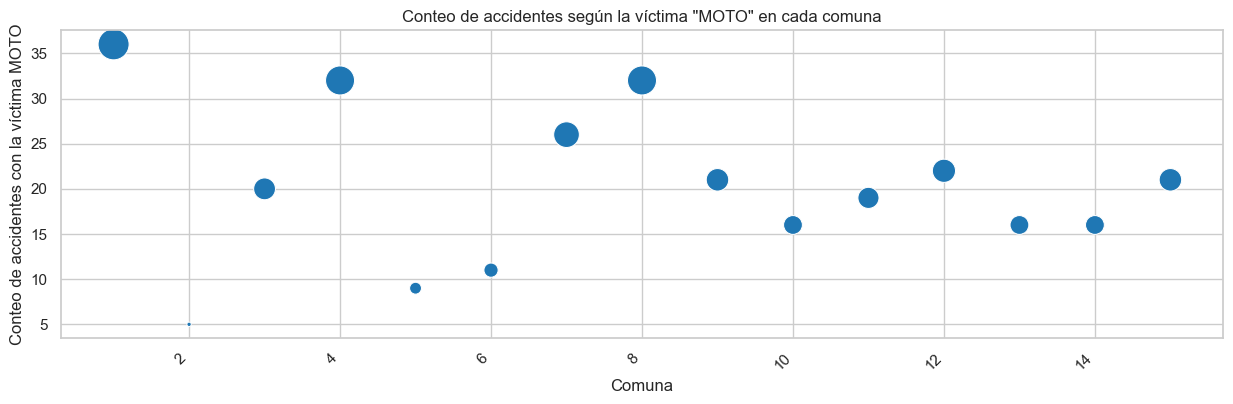

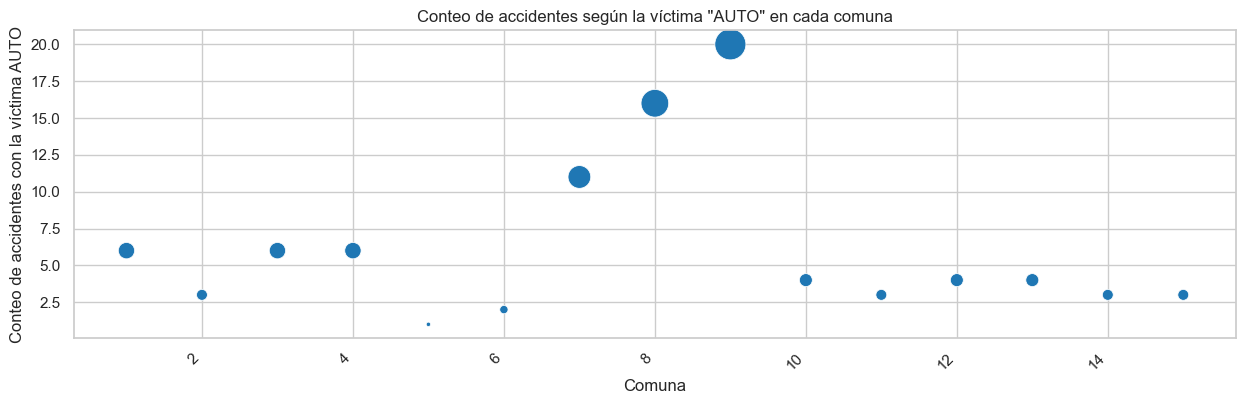

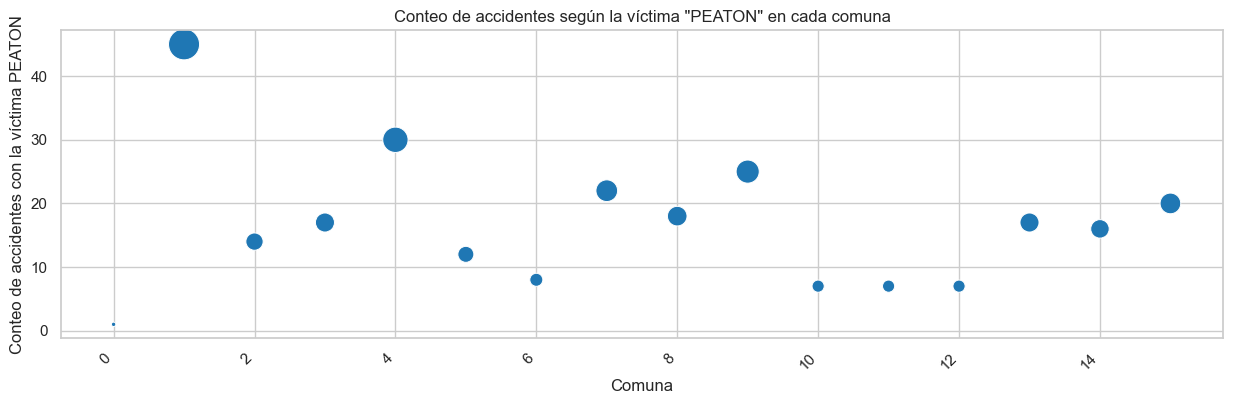

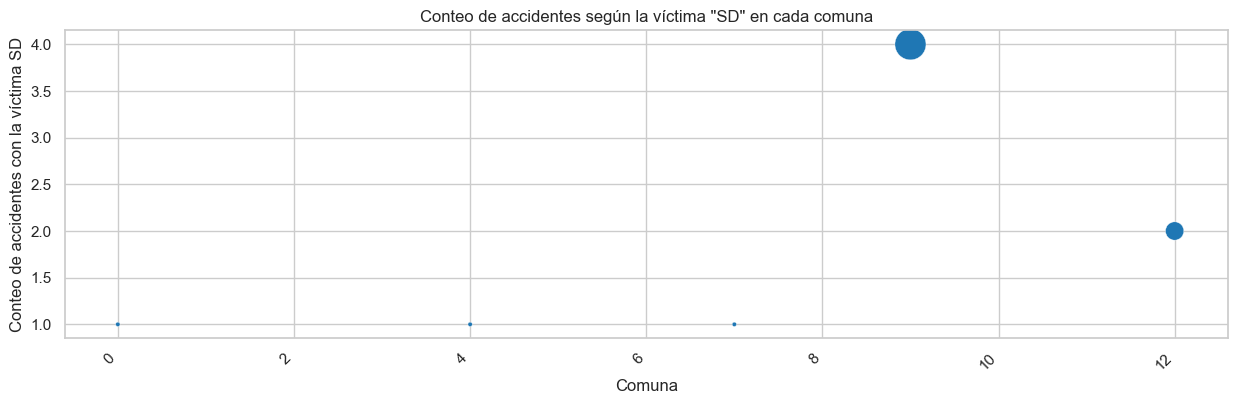

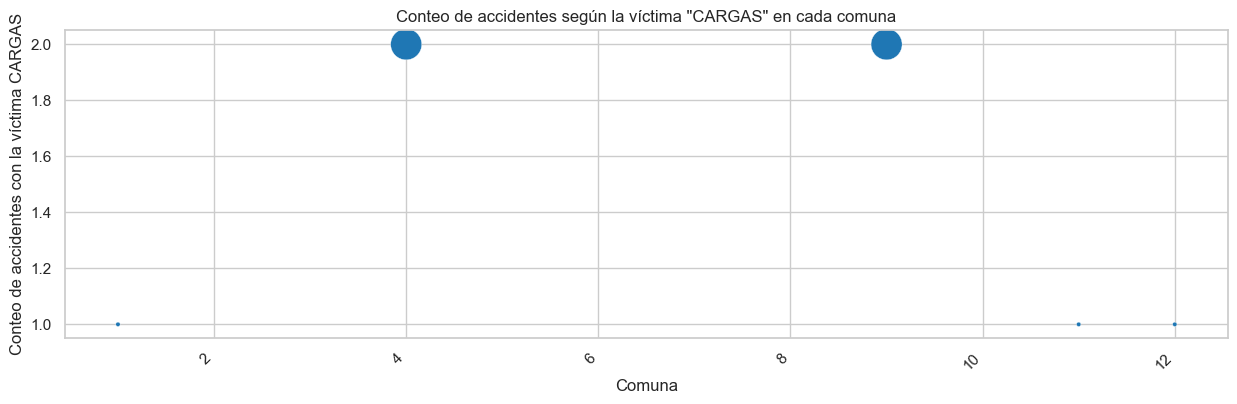

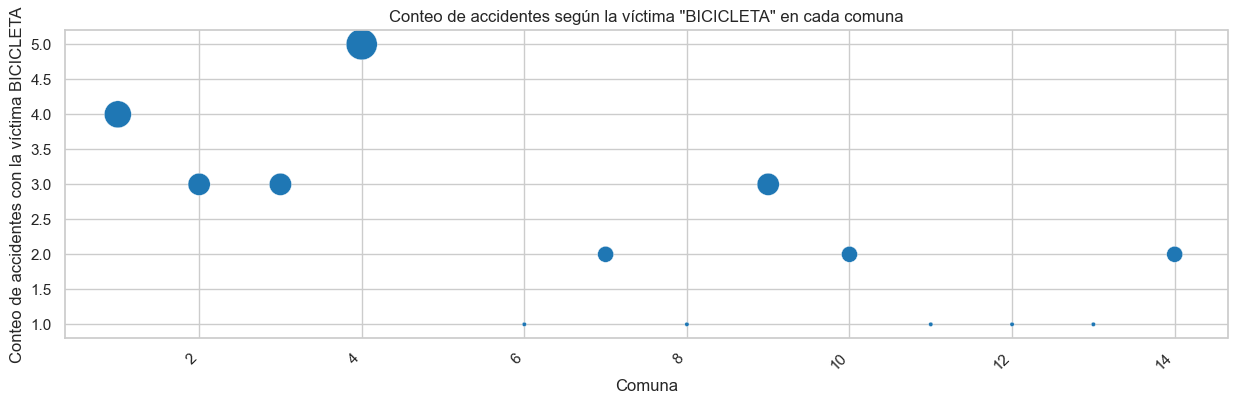

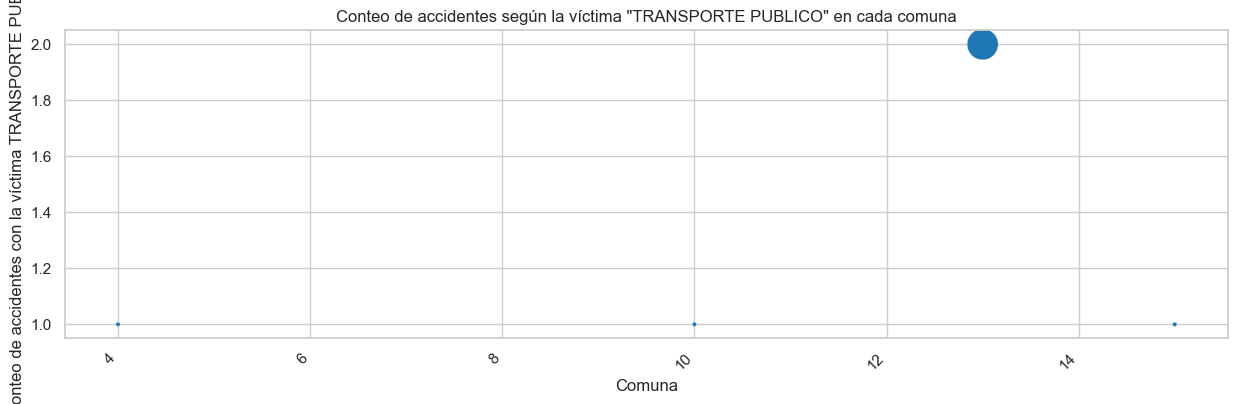

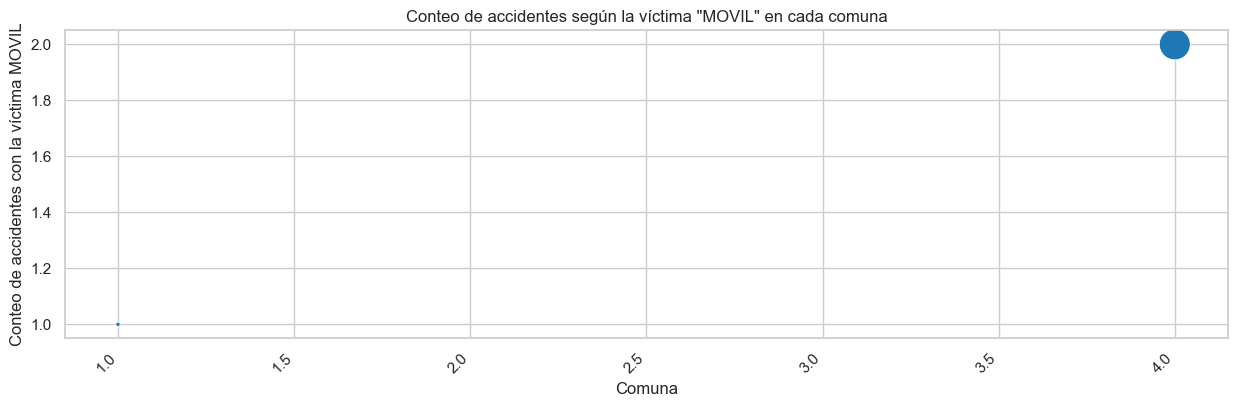

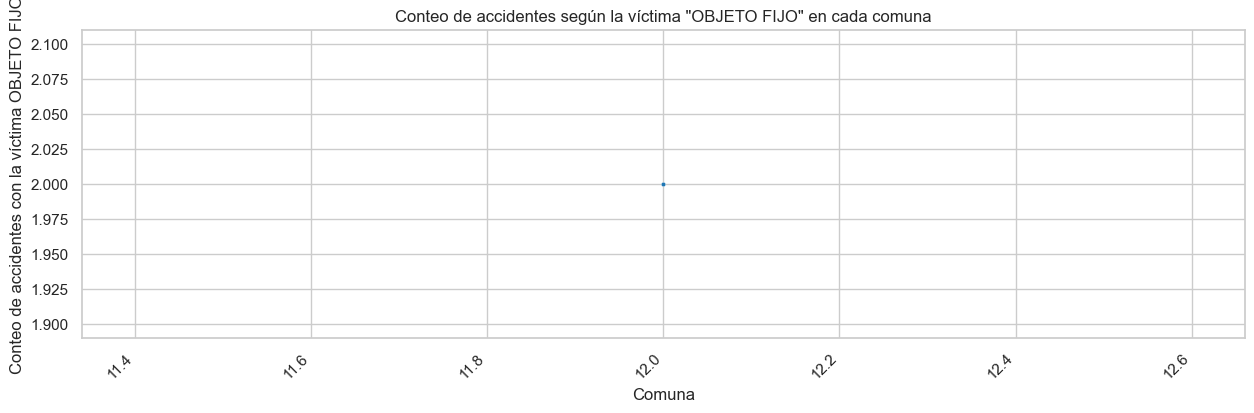

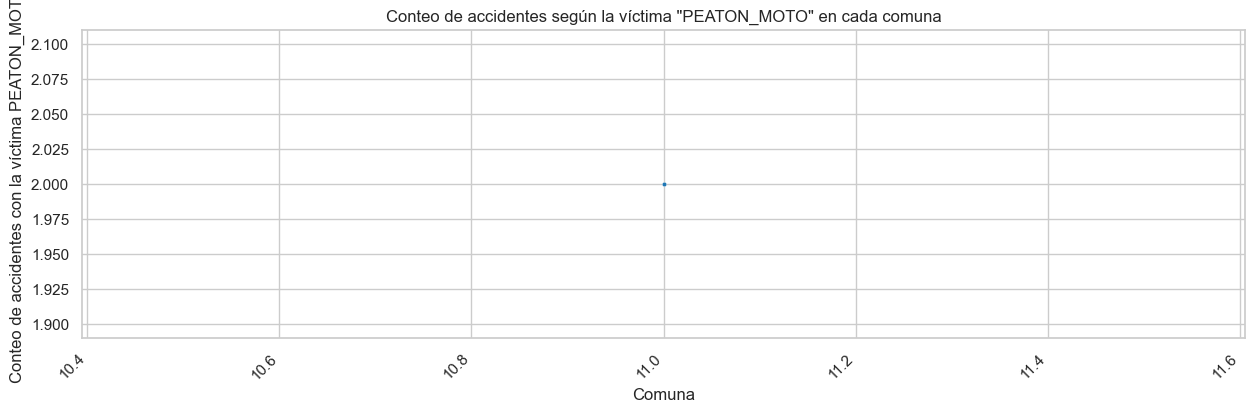

In [199]:
# Agrupar los datos por COMUNA y VICTIMA para contar el número de accidentes en cada comuna según la víctima

conteo_victima_comuna = df_merged.groupby(['COMUNA', 'VICTIMA']).size().reset_index(name='Cantidad')

victimas = df_merged['VICTIMA'].unique()

for victima in victimas:
    plt.figure(figsize=(15, 4))
    
    data_filtrada = conteo_victima_comuna[conteo_victima_comuna['VICTIMA'] == victima]
    
    sns.scatterplot(
        data=data_filtrada, 
        x='COMUNA', 
        y='Cantidad',  
        size='Cantidad',  
        legend=False, 
        sizes=(10, 500), 
        color='tab:blue'
    )
    
    plt.ylabel(f'Conteo de accidentes con la víctima {victima}')
    plt.xlabel('Comuna')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Conteo de accidentes según la víctima "{victima}" en cada comuna')
    plt.show()


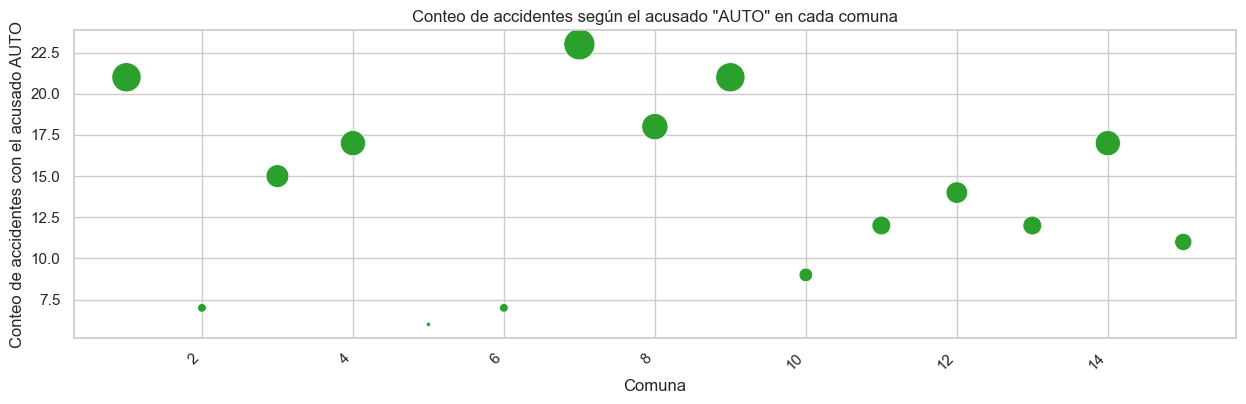

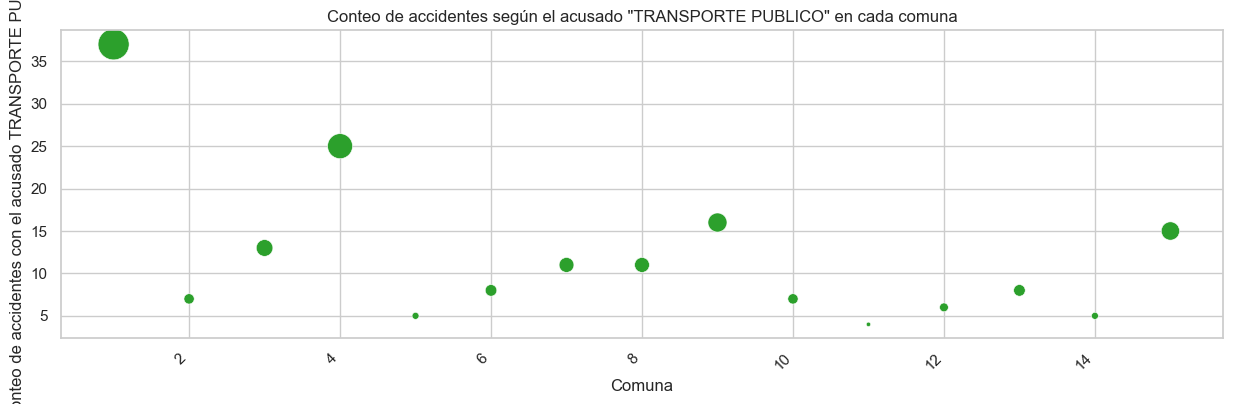

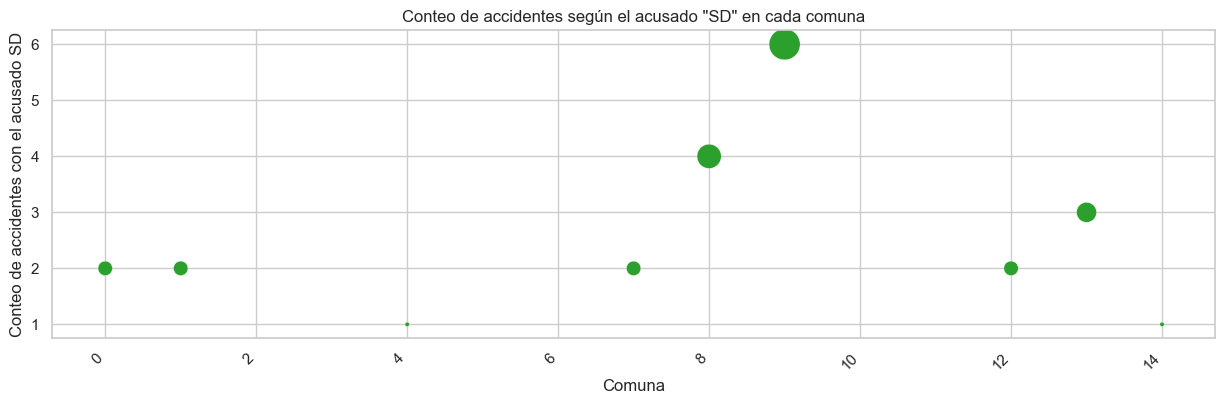

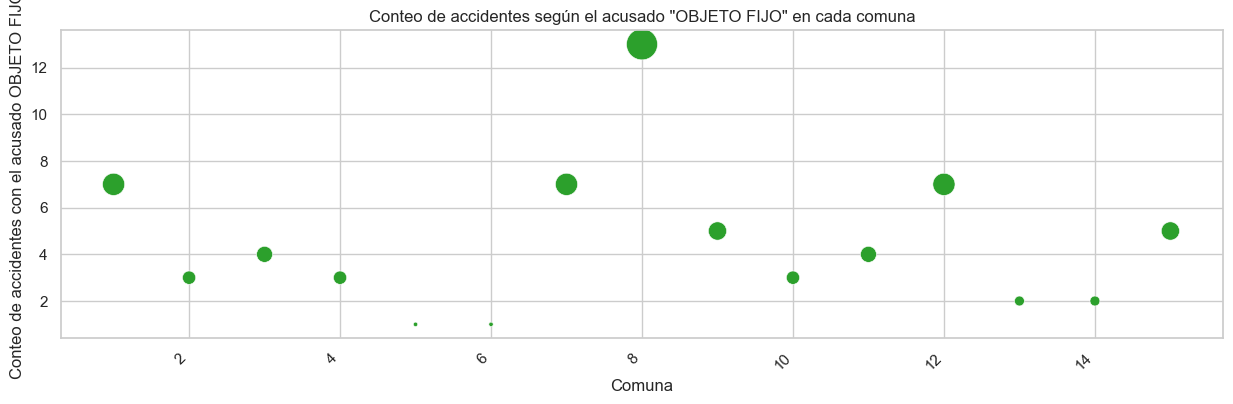

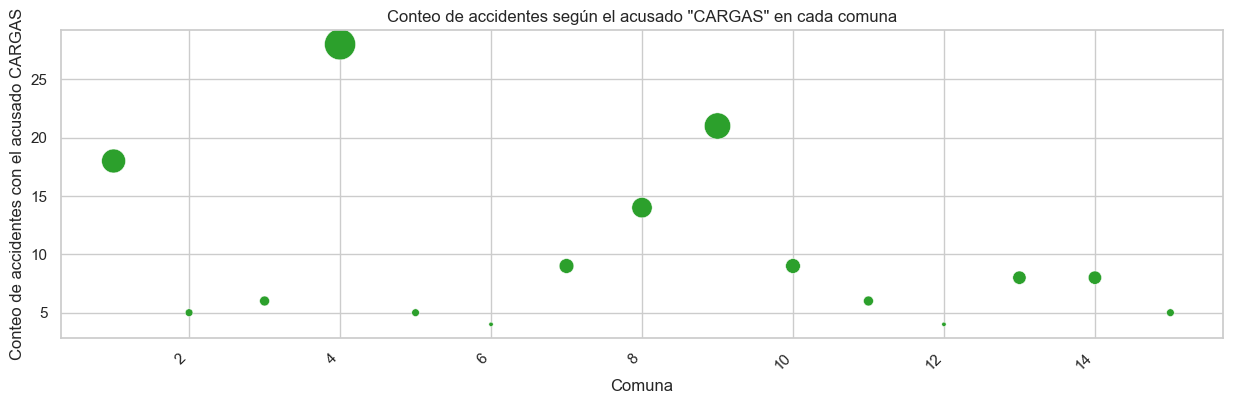

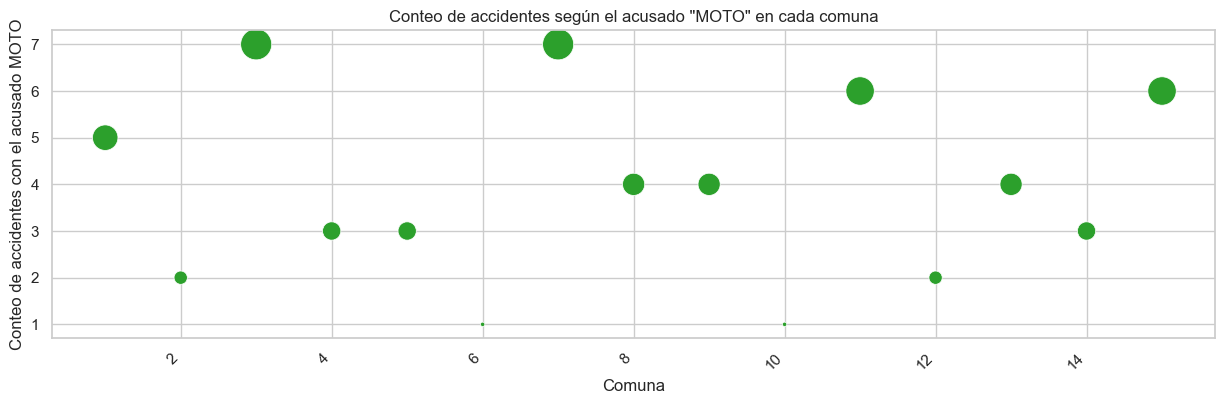

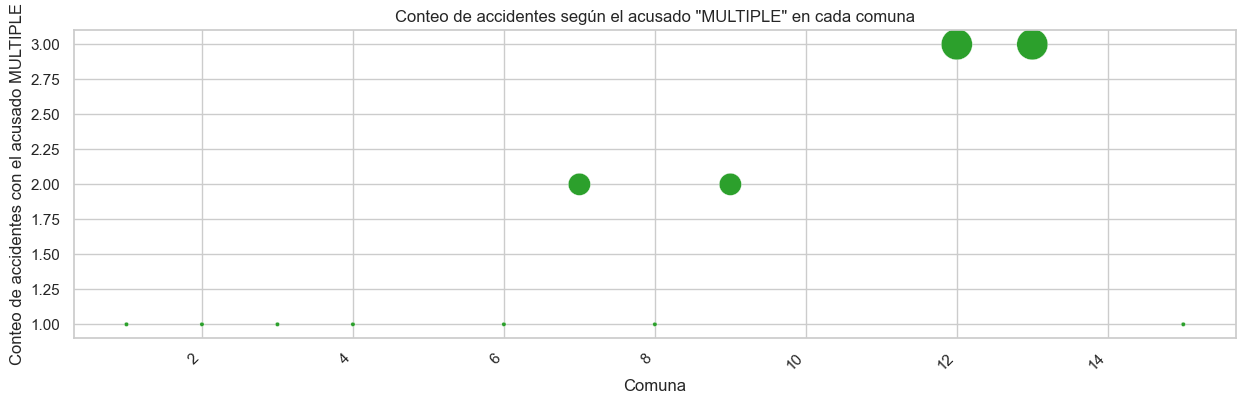

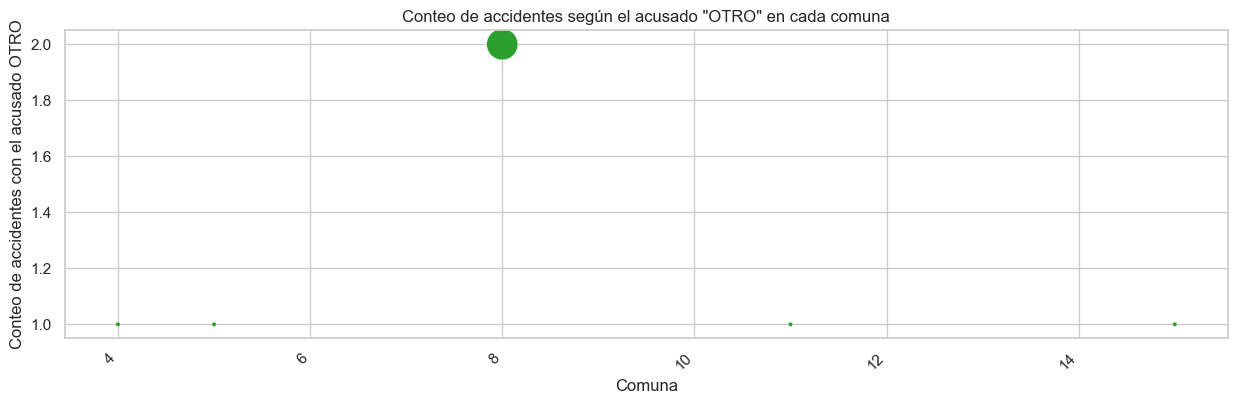

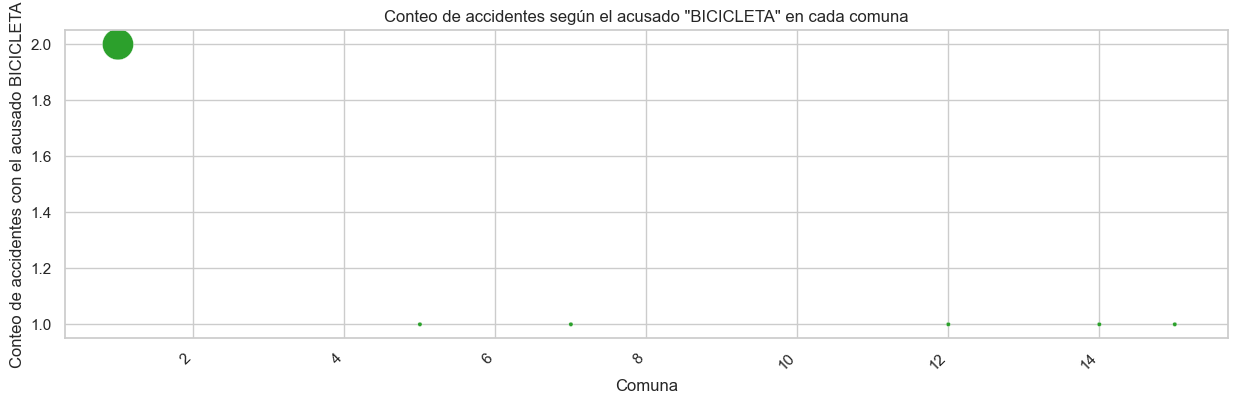

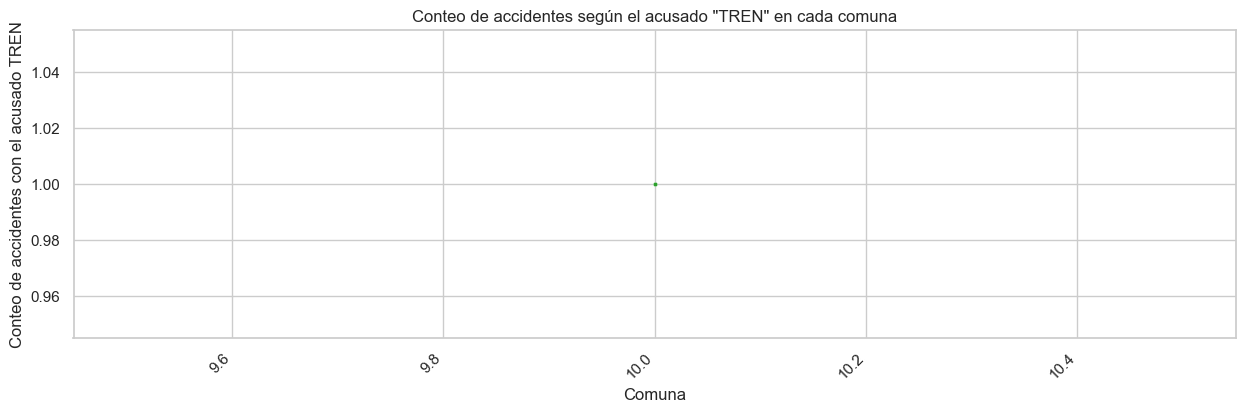

In [200]:
# Agrupar los datos por COMUNA y ACUSADO para contar el número de accidentes en cada comuna según el rol

conteo_acusado_comuna = df_merged.groupby(['COMUNA', 'ACUSADO']).size().reset_index(name='Cantidad')

acusados = df_merged['ACUSADO'].unique()

for acusado in acusados:
    plt.figure(figsize=(15, 4))
    
    data_filtrada = conteo_acusado_comuna[conteo_acusado_comuna['ACUSADO'] == acusado]
    
    sns.scatterplot(
        data=data_filtrada, 
        x='COMUNA', 
        y='Cantidad',  
        size='Cantidad',  
        legend=False, 
        sizes=(10, 500), 
        color='tab:green'
    )
    
    plt.ylabel(f'Conteo de accidentes con el acusado {acusado}')
    plt.xlabel('Comuna')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Conteo de accidentes según el acusado "{acusado}" en cada comuna')
    plt.show()

In [208]:
# Agrupar por 'Cruce' y contar las filas
accidentes_por_cruce = dfsiniestros.groupby('Cruce').size().reset_index(name='conteos')

# Encontrar el cruce con más accidentes
cruce_maximo = accidentes_por_cruce.loc[accidentes_por_cruce['conteos'].idxmax()]

# Mostrar el resultado
print(f"El cruce con más accidentes es: {cruce_maximo['Cruce']} con {cruce_maximo['conteos']} accidentes.")

El cruce con más accidentes es: 27 DE FEBRERO AV. y ESCALADA AV. con 5 accidentes.


Conclusiones:

Se quiso ver en qué comunas era mas frecuentes los accidentes, agrupando primero por la víctima, y luego del vehículo registrado como acusado.
- La comuna 1 posee más accidentes con motociclistas involucrados como víctimas, siguiéndole en cantidad la comuna 4 y 8.
- La comuna 9 posee más registros de accidentes con autos involucrados como víctimas.
- En la comuna 1, hay más de 40 registros de peatón como víctima.
- En la categoría CARGAS como víctima solo se poseen 4 registros, en la comuna 4 y 9.
- En colisiones con bicicletas como víctimas, podemos ver que se destacan la comuna 4 y la 1.
- Las comunas 7 y 9 presentan más registros con autos como contraparte de la víctima.
- La comuna 1 presenta más de 35 registros con transporte público como acusado.
- En la comuna 8 podemos ver 12 siniestros producidos por un objeto fijo.
- Existen más de 25 datos de accidentes provocados por la categoría CARGAS en la comuna 4.
- Con el acusado como el vehículo motocicleta podemos ver la comuna 3 y 7, con 7 registros cada una.

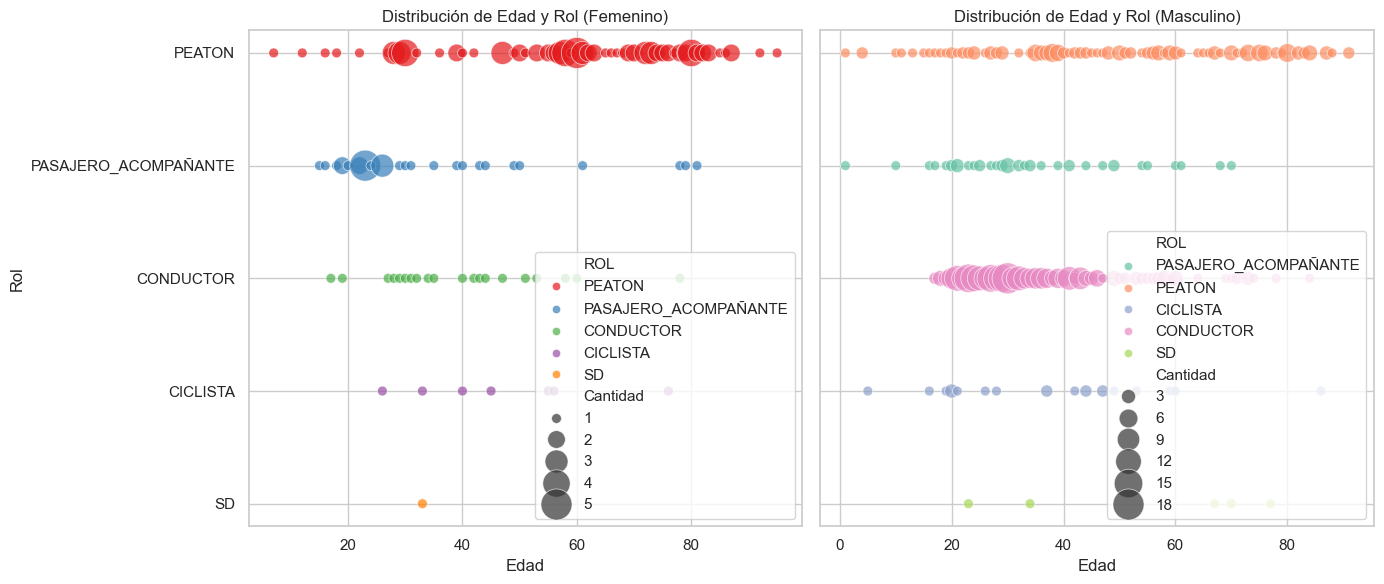

In [202]:


# Agrupar por SEXO, EDAD, ROL para contar la cantidad de casos en cada combinación
conteo_casos = df_merged.groupby(['SEXO', 'EDAD', 'ROL']).size().reset_index(name='Cantidad')

# Creamos la figura y los ejes (2 gráficos, uno para cada sexo)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # 1 fila, 2 columnas

# Gráfico para sexo femenino
sns.scatterplot(
    data=conteo_casos[conteo_casos['SEXO'] == 'FEMENINO'],
    x='EDAD', 
    y='ROL',
    size='Cantidad',  # Tamaño del punto según el conteo de casos
    sizes=(50, 500),  # Ajustar el tamaño de los puntos
    hue='ROL',
    alpha=0.7,
    palette='Set1',
    ax=axs[0]  # Asignar al primer gráfico (columna 1)
)
axs[0].set_title('Distribución de Edad y Rol (Femenino)')
axs[0].set_xlabel('Edad')
axs[0].set_ylabel('Rol')

# Gráfico para sexo masculino
sns.scatterplot(
    data=conteo_casos[conteo_casos['SEXO'] == 'MASCULINO'],
    x='EDAD', 
    y='ROL',
    size='Cantidad',  # Tamaño del punto según el conteo de casos
    sizes=(50, 500),
    hue='ROL',
    alpha=0.7,
    palette='Set2',
    ax=axs[1]  # Asignar al segundo gráfico (columna 2)
)
axs[1].set_title('Distribución de Edad y Rol (Masculino)')
axs[1].set_xlabel('Edad')

# Ajustar el diseño para que no se sobrepongan los títulos y etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Podemos ver que los casos más observados son con personas del sexo masculino entre 20 y 40 años de edad, como conductores.

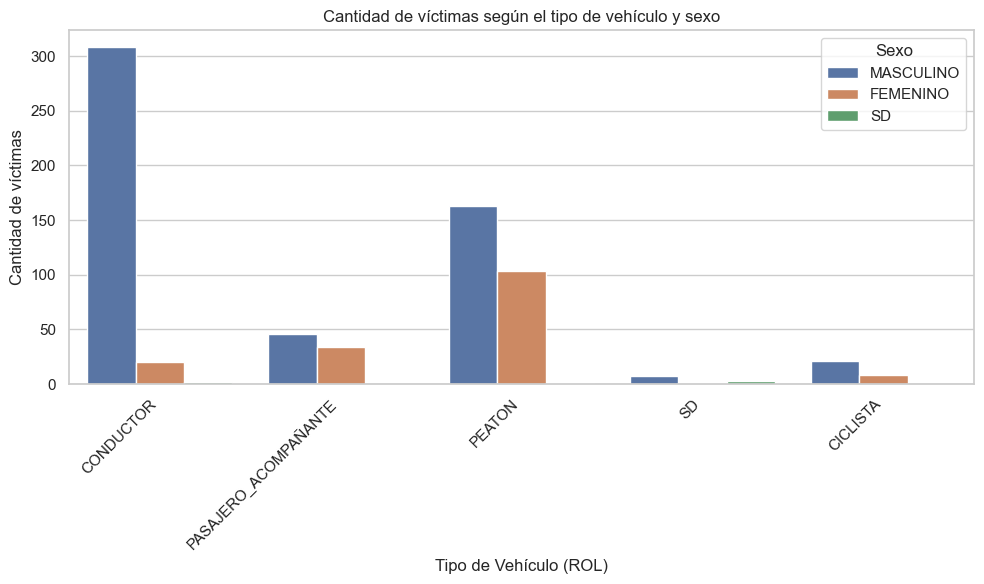

In [203]:
# Gráfico de barras que muestre la cantidad de víctimas por tipo de vehículo y sexo
plt.figure(figsize=(10, 6))

sns.countplot(data=dfvictimas, x='ROL', hue='SEXO')

plt.title('Cantidad de víctimas según el tipo de vehículo y sexo')
plt.xlabel('Tipo de Vehículo (ROL)')
plt.ylabel('Cantidad de víctimas')
plt.xticks(rotation=45, ha='right')

plt.legend(title='Sexo')
plt.tight_layout()
plt.show()


Podemos ver que en el caso de peaton y pasajero acompañante, existe más homogeneidad de registros entre los dos datos, pero sigue prevaleciendo el género masculino.

In [204]:
df_merged.to_excel('df_merged.xlsx', index=False)
